In [ ]:
# First, install dependencies
!pip install numpy pandas scipy matplotlib scikit-learn category_encoders matplotlib-venn xgboost seaborn


In [ ]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, cross_val_score
from category_encoders.target_encoder import TargetEncoder
from matplotlib_venn import venn3, venn3_circles
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, completeness_score, homogeneity_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif, mutual_info_regression, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import time
import seaborn as sns


seed = 43

# Get access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path
dataset_path = "/content/drive/My Drive/Projects (Github)/NF-UNSW-NB15/subset-cleanedNFdata.csv"
df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')

print(df.shape)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(24332, 24)


In [ ]:
# For some reason the datatypes from the cleaning process is overrided. So here the datatypes is changed again identically to the last part of the previous notebook.
df['IP_src'] = df['IP_src'].astype('category')
df['IP_SRC_1'] = df['IP_SRC_1'].astype('category')
df['IP_SRC_2'] = df['IP_SRC_2'].astype('category')
df['IP_SRC_3'] = df['IP_SRC_3'].astype('category')
df['IP_SRC_4'] = df['IP_SRC_4'].astype('category')

df['Port_src'] = df['Port_src'].astype('category')
df['Port_src_group'] = df['Port_src_group'].astype('category')

df['IP_dst'] = df['IP_dst'].astype('category')
df['IP_DST_1'] = df['IP_DST_1'].astype('category')
df['IP_DST_2'] = df['IP_DST_2'].astype('category')
df['IP_DST_3'] = df['IP_DST_3'].astype('category')
df['IP_DST_4'] = df['IP_DST_4'].astype('category')

df['Port_dst'] = df['Port_dst'].astype('category')
df['Port_dst_group'] = df['Port_dst_group'].astype('category')

df['Proto'] = df['Proto'].astype('category')
df['L7proto'] = df['L7proto'].astype('category')
df['TCP_flags'] = df['TCP_flags'].astype('category')

df['Attack'] = df['Attack'].astype('category')


df.dtypes

IP_src            category
Port_src          category
IP_dst            category
Port_dst          category
Proto             category
L7proto           category
InBytes              int64
OutBytes             int64
InPkts               int64
OutPkts              int64
TCP_flags         category
FlowDurMS            int64
IP_SRC_1          category
IP_SRC_2          category
IP_SRC_3          category
IP_SRC_4          category
IP_DST_1          category
IP_DST_2          category
IP_DST_3          category
IP_DST_4          category
Port_dst_group    category
Port_src_group    category
Attack            category
Label                int64
dtype: object

In [ ]:
df.head(3).T

,0,1,2
IP_src,59.166.0.8,59.166.0.6,59.166.0.7
Port_src,22023,26214,10429
IP_dst,149.171.126.2,149.171.126.9,149.171.126.2
Port_dst,1577,37823,2854
Proto,6,17,6
L7proto,36.0,11.0,0.0
InBytes,2854,536,2766
OutBytes,30622,304,25812
InPkts,46,4,44
OutPkts,48,4,46


# Initial basic analysis

In [ ]:
# To get a sense of our data we can use the describe function

pd.set_option('display.float_format', '{:.2f}'.format)

df.describe()


,InBytes,OutBytes,InPkts,OutPkts,FlowDurMS,Label
count,24332.00,24332.00,24332.00,24332.00,24332.00,24332.00
mean,6154.86,43620.25,40.41,51.68,59277.69,0.04
std,120252.76,194667.11,112.46,146.42,498963.33,0.21
min,64.00,0.00,1.00,0.00,0.00,0.00
25%,520.00,304.00,4.00,4.00,0.00,0.00
50%,1958.00,3276.00,16.00,18.00,7.00,0.00
75%,3784.00,20826.00,50.00,46.00,169.00,0.00
max,14657244.00,10810586.00,11038.00,8108.00,4294952.00,1.00


In [ ]:
# Also consider the categorical features (transposed for readability)
df.describe(include='category').T


,count,unique,top,freq
IP_src,24332,32,59.166.0.0,2344
Port_src,24332,20077,0,185
IP_dst,24332,36,149.171.126.1,2358
Port_dst,24332,8174,53,4355
Proto,24332,112,6,17499
L7proto,24332.00,65.00,0.00,7739.00
TCP_flags,24332,9,27,16500
IP_SRC_1,24332,4,59,22623
IP_SRC_2,24332,4,166,22623
IP_SRC_3,24332,5,0,22623


# Splitting data

In [ ]:
# To ensure that we can get an equal representation of all the attacks in the dataset, we can create a numbered label that distinguishes in between each attack.
# Thereafter we are able to create a new attack variable (y_stratify). We are then able to use the built-in stratify function in train_test_split
# Currently it is a binary 0 and 1 between non attack and attack. I will return to this state once I have ensured equal representation of all attacks.

label_to_number = {
    'Benign': 0,
    'Exploits': 1,
    'Fuzzers': 2,
    'Reconnaissance': 3,
    'Generic': 4,
    'DoS': 5,
    'Shellcode': 6,
    'Backdoor': 7,
    'Analysis': 8,
    'Worms': 9
}

# Replace the values in the 'Attack' column with their corresponding numbers
Y_stratify = df['Attack'].replace(label_to_number) # New attack variable that replaces the cat values with numbered values
Y = df['Label'] # Binary target variable (Which will function as our primary target variable)
X = df.drop(['Label', 'Attack'], axis=1) # Everything except for our two target variables, so they are dropped here

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, # Our X and Y variables are already defined above
                                                    test_size = 0.2, # 20% test 80 % train
                                                    random_state=42, # reproducibility
                                                    stratify=Y_stratify) # equal representation of all attack types in both sets.






In [ ]:
# Sanity check - dimension check
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(19465, 22)
(4867, 22)
(19465,)
(4867,)


In [ ]:
# Lastly before preprocessing, I decide to remove the full IP feature as the info exist separately in their octet feature
#Remove for train
X_train = X_train.drop('IP_src', axis=1)
X_train = X_train.drop('IP_dst', axis=1)
# Remove for test
X_test = X_test.drop('IP_src', axis=1)
X_test = X_test.drop('IP_dst', axis=1)

# Preprocessing

Preprocessing can be created and happen on both datatypes with the help of ColumnTransformer function.

This ensures that the same scaling transformation is applied to both your training and test data, which is important to get meaningful results. In this way, the scaling parameters (like the median and interquartile range used in RobustScaler) are only calculated from the training set, preventing any data leakage from the test set.

However, the TargetEncoding will be done separately as I did not find a way to incorporate that into the ColumnTransformer function effectively.

### Separation of datatypes

I separate all the features in following three groups / variables

1.   Numerical features
2.   Categorical features with low cardinality
3.   Categorical features with high cardinality

I defined the threshold for low cardinality to be a feature that has anything above 50 unique values

In [ ]:
# Separate my features into numerical and categorical variables.
num_feat_train = X_train.select_dtypes(include=['int64', 'float64'])
cat_feat_train = X_train.select_dtypes(include=['category'])

# Further separate my categorical features based on their cardinality. I have made the threshold 50
high_cardinality_features = [] # empty list to store the column names
low_cardinality_features = [] # empty list to store the column names
threshold = 50  # adjustable

# Loop that separates the cat features.
for column in cat_feat_train.columns:
    if len(cat_feat_train[column].unique()) > threshold:
        high_cardinality_features.append(column)
    else:
        low_cardinality_features.append(column)

# Use the two lists to create two separate sets of features
cat_feat_train_high = cat_feat_train[high_cardinality_features]
cat_feat_train_low = cat_feat_train[low_cardinality_features]

# TEST SET
# I do the same for the test set.
num_feat_test = X_test.select_dtypes(include=['int64', 'float64'])
cat_feat_test = X_test.select_dtypes(include=['category'])

# This ensures that the same features that were considered high cardinality in the training set are also considered high cardinality in the test set and vice versa.
# This is important to keep the training and test data consistent.
cat_feat_test_high = cat_feat_test[high_cardinality_features]
cat_feat_test_low = cat_feat_test[low_cardinality_features]

In [ ]:
# Check which cat features are low and high
print(cat_feat_train_high.columns)
print(cat_feat_train_low.columns)

Index(['Port_src', 'Port_dst', 'Proto', 'L7proto'], dtype='object')
Index(['TCP_flags', 'IP_SRC_1', 'IP_SRC_2', 'IP_SRC_3', 'IP_SRC_4', 'IP_DST_1',
       'IP_DST_2', 'IP_DST_3', 'IP_DST_4', 'Port_dst_group', 'Port_src_group'],
      dtype='object')


## Test for normal distribution on numerical values

Plotting our data to a histogram is an easy way to see if we have normal distribution. With this heavily skewed data, we can consider log10 transforming the data and plot to a histogram. Lastly we can use QQ plots as a way to test normality. I qqplot both the log transformed numerical features and the normal numerical features


[[<Axes: title={'center': 'InBytes'}>
  <Axes: title={'center': 'OutBytes'}>]
 [<Axes: title={'center': 'InPkts'}> <Axes: title={'center': 'OutPkts'}>]
 [<Axes: title={'center': 'FlowDurMS'}> <Axes: >]]


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


[[<Axes: title={'center': 'InBytes'}>
  <Axes: title={'center': 'OutBytes'}>]
 [<Axes: title={'center': 'InPkts'}> <Axes: title={'center': 'OutPkts'}>]
 [<Axes: title={'center': 'FlowDurMS'}> <Axes: >]]


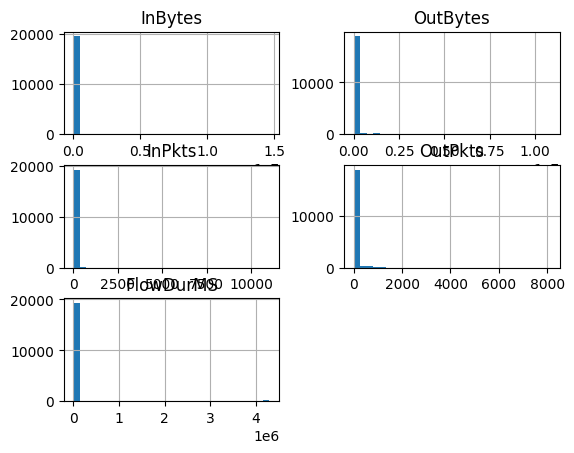

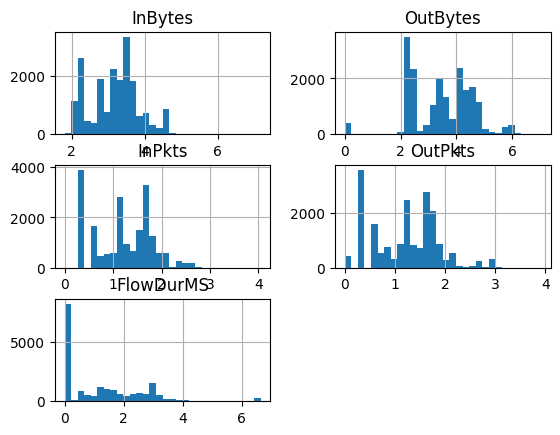

In [ ]:
print(num_feat_train.hist(bins=30)) # Histogram of our numerical values - it is not useful given how heavily skewed it is

num_feat_train_logtrans = np.log10(num_feat_train).replace(-np.inf, 0) # log transform train
num_feat_test_logtrans = np.log10(num_feat_test).replace(-np.inf, 0) # log transform test

print(num_feat_train_logtrans.hist(bins=30)) # Histogram of the log transformed numerical features

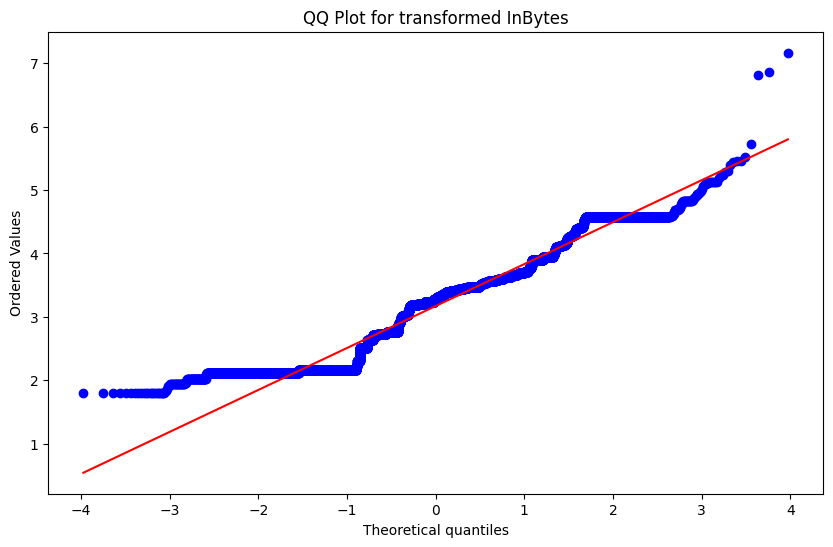

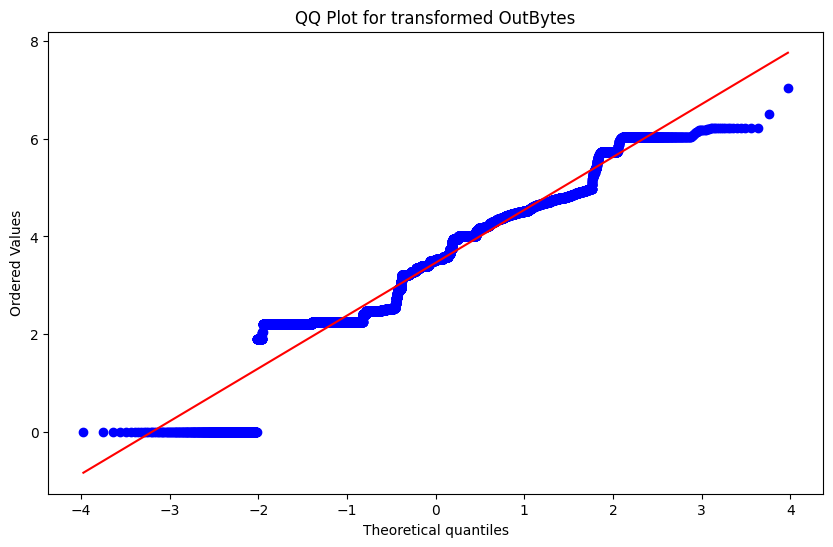

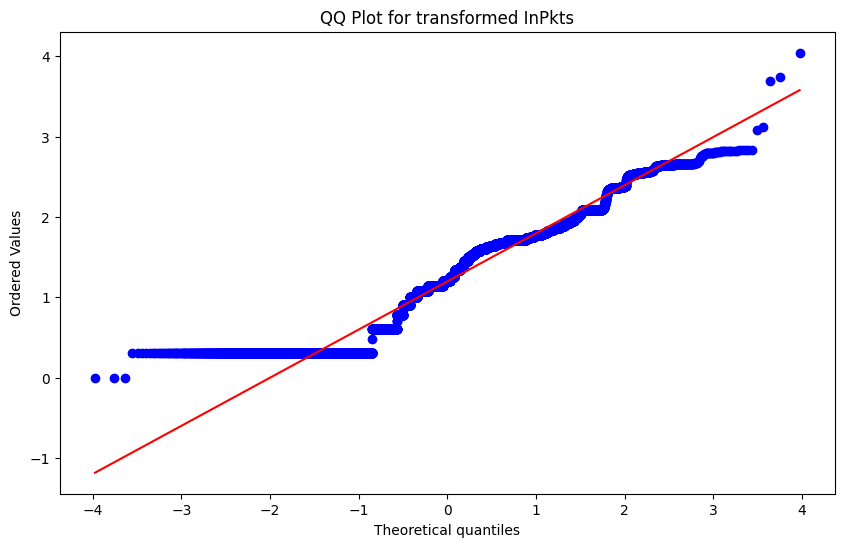

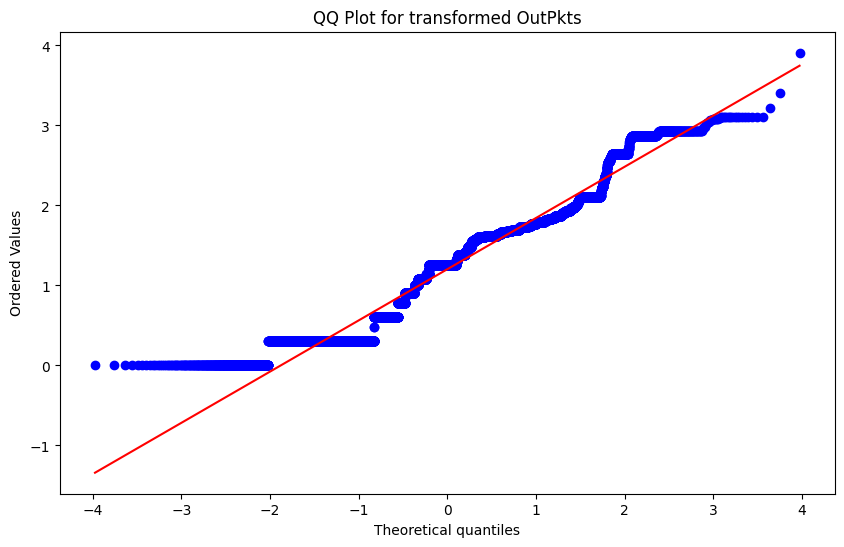

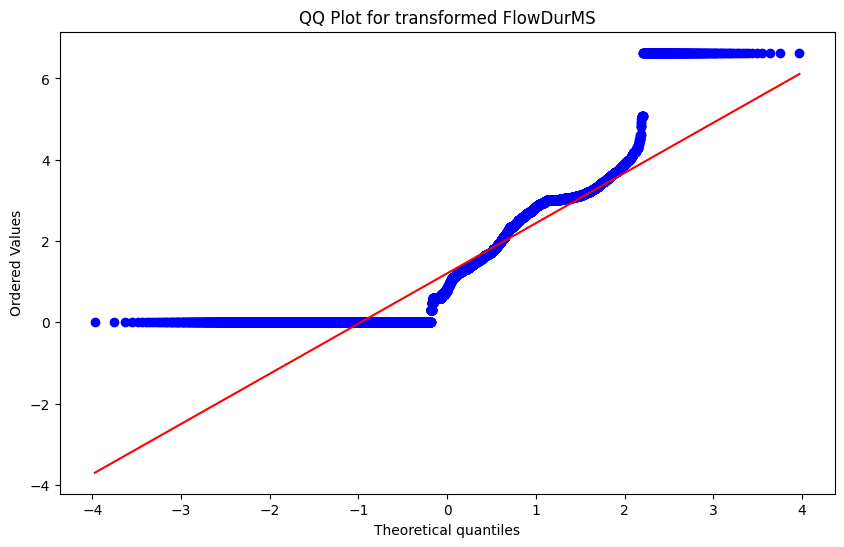

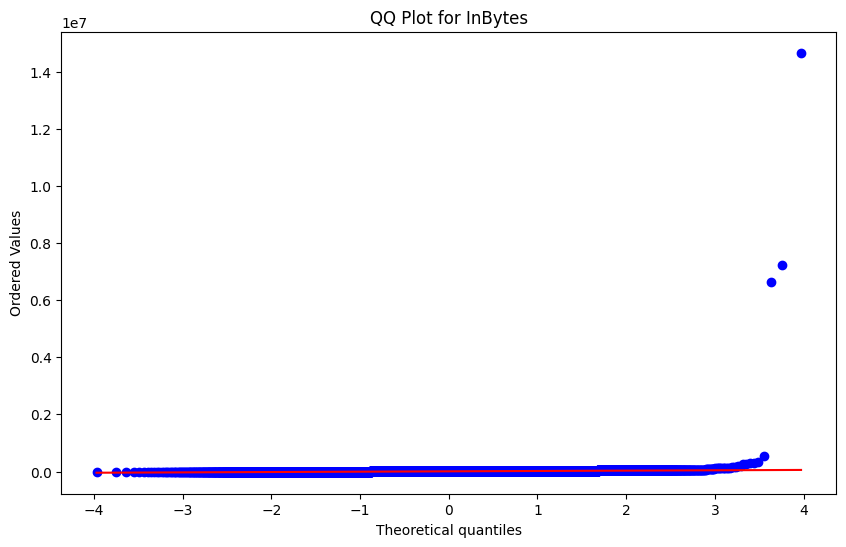

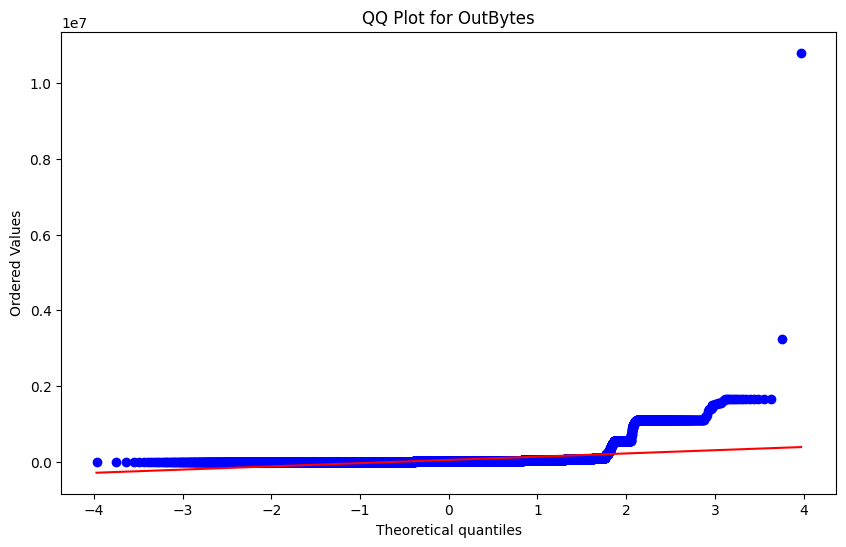

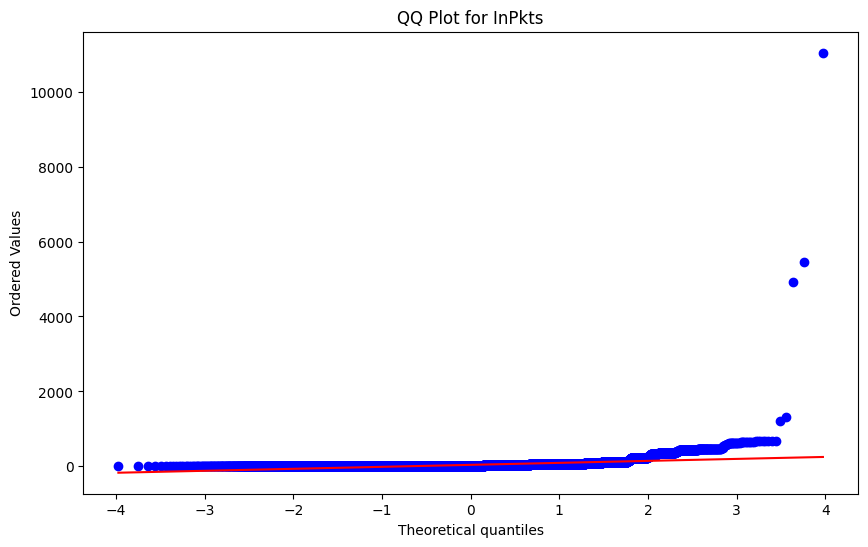

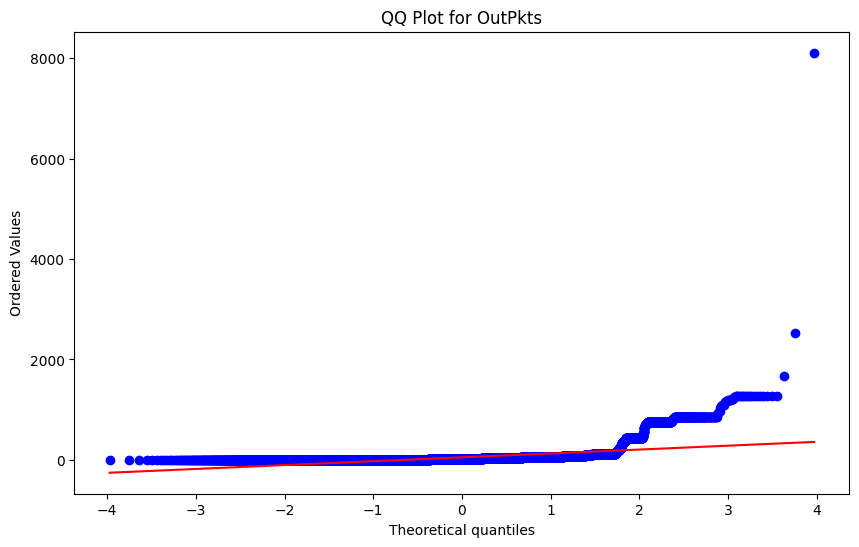

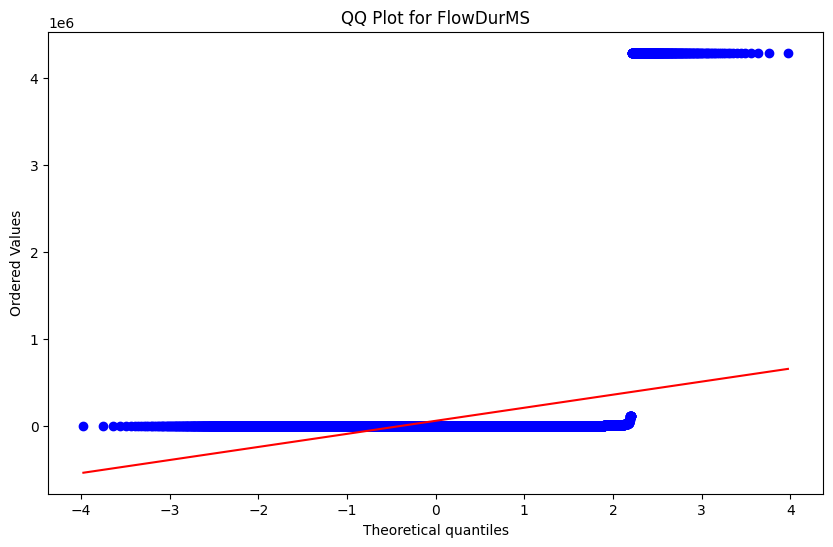

In [ ]:
# Select only numeric datatypes
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = num_feat_train_logtrans.select_dtypes(include=numerics)

for feature in numeric_df.columns:
    plt.figure(figsize=(10,6))

    # QQ plot
    stats.probplot(numeric_df[feature].dropna(), dist="norm", plot=plt)

    plt.title(f'QQ Plot for transformed {feature}')
    plt.show()

# Select only numeric datatypes
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = num_feat_train.select_dtypes(include=numerics)

for feature in numeric_df.columns:
    plt.figure(figsize=(10,6))

    # QQ plot
    stats.probplot(numeric_df[feature].dropna(), dist="norm", plot=plt)
    plt.title(f'QQ Plot for {feature}')
    #plt.ylim(-1000, 1000) # To see the results better, this limiter can be applied.
    plt.show()

### Notes for QQ plot

- Linearity: Data points on the QQ plot should fall approximately along a straight line. This line represents the theoretical quantiles from the chosen theoretical distribution (a normal distribution, in this case).
-  Deviations at the Ends: Be particularly careful about how your data points behave at the ends of the plot (i.e., in the tails of the distribution). In many cases, data may seem to fit a normal distribution except for a few outliers or heavy tails. In a QQ plot, this might look like a curve that follows the line but deviates from it at the ends.
- Outliers: Outliers will appear as points that deviate strongly from the line. A few outliers may not invalidate the assumption of normality, especially if your sample size is large, but many outliers or outliers that deviate strongly from the line could be a problem.


Given this, it is fair to conclude that our numerical values are **not** normally distributed




## Preprocessing steps

1. Preprocess the categorical features with high cardinality
  - TargetEncoding is an option here, but we need to be careful with overfitting and data leakage. The smoothing parameter is a way to avoid that.

2. Put the preprocessed high cardinality cat features back together with low cardinality cat features and numerical features (concatenate)

3. Create a pipeline in ColumnTransfer for both cat (low cardinality) and num features.
 - Another version of ColumnTransfer, as there may be situations where some categories from the test set does not exist in the training set.

4. Print out the column names to see what new features are made with one-hot-encoding

#TargetEncoding (IMPORTANT NOTE HERE)

This turned out to have a negative overfitting effect on the feature selection process when the dataset is so small compared to the original. Introducing the high cardinality features as target encoded did change the correlations and relationships between features. Even though the high cardinality features were not directly selected by RFE, their presence did influence the importance of other features and did overfit quick. If  high cardinality features are highly correlated (or anti-correlated) with the target variable, they can cause other features to seem more (or less) important than they actually are.

That is why these features are excluded during the ColumnTransfer pipeline and also for getting the feature names further down below. You can experiment by removing them as comments and run the program.

In [ ]:
print(cat_feat_train_high.nunique())
print(cat_feat_train_high.describe())

Port_src    16598
Port_dst     6683
Proto         101
L7proto        61
dtype: int64
        Port_src  Port_dst  Proto  L7proto
count      19465     19465  19465 19465.00
unique     16598      6683    101    61.00
top            0        53      6     0.00
freq         156      3516  13967  6203.00


In [ ]:
# Initialize a target encoder
encoder = TargetEncoder(smoothing=5000) #This hyperparameter needs to be adjusted to ensure overfitting / underfitting

# Fit the encoder using the high cardinality features and target
encoder.fit(cat_feat_train_high, Y_train)  # Y_train is the target variable

# Transform the features
cat_feat_train_high_encoded = encoder.transform(cat_feat_train_high)
cat_feat_test_high_encoded = encoder.transform(cat_feat_test_high)

# So we see output values with 2 decimals
pd.set_option('display.float_format', '{:.2f}'.format)

# Test it out and consider the maxes - it cannot be 1 or so near 1. Adjust smoothing accordingly
print(cat_feat_train_high_encoded.nunique())
print(cat_feat_train_high_encoded.describe())


Port_src    14
Port_dst    37
Proto       10
L7proto     29
dtype: int64
       Port_src  Port_dst    Proto  L7proto
count  19465.00  19465.00 19465.00 19465.00
mean       0.04      0.04     0.04     0.04
std        0.10      0.07     0.04     0.05
min        0.02      0.02     0.02     0.02
25%        0.02      0.02     0.03     0.02
50%        0.02      0.02     0.04     0.04
75%        0.02      0.05     0.04     0.05
max        0.52      0.52     0.52     0.52


In [ ]:
#  Concatenate the encoded features with numerical and low cardinality features:
X_train_preprocessed = pd.concat([num_feat_train, cat_feat_train_low, cat_feat_train_high_encoded], axis=1)
X_test_preprocessed = pd.concat([num_feat_test, cat_feat_test_low, cat_feat_test_high_encoded], axis=1)

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), list(num_feat_train.columns)),
        ('cat', OneHotEncoder(handle_unknown='ignore'), list(cat_feat_train_low.columns))
    ])

# Fit the preprocessor
preprocessor.fit(X_train_preprocessed)

# Get the OneHotEncoder from the preprocessor
encoder = preprocessor.named_transformers_['cat']

# Get the categories learned by the encoder
learned_categories = encoder.categories_

# For each categorical feature, find the unknown categories in the test set
for i, col in enumerate(list(cat_feat_train_low.columns)):
    test_categories = X_test_preprocessed[col].unique()
    unknown_categories = np.setdiff1d(test_categories, learned_categories[i])
    print(f"Unknown categories in {col}: {unknown_categories}")

# Transform the data
X_train_final = preprocessor.transform(X_train_preprocessed)
X_test_final = preprocessor.transform(X_test_preprocessed)


Unknown categories in TCP_flags: []
Unknown categories in IP_SRC_1: []
Unknown categories in IP_SRC_2: []
Unknown categories in IP_SRC_3: []
Unknown categories in IP_SRC_4: []
Unknown categories in IP_DST_1: []
Unknown categories in IP_DST_2: []
Unknown categories in IP_DST_3: [182]
Unknown categories in IP_DST_4: [255]
Unknown categories in Port_dst_group: []
Unknown categories in Port_src_group: []


## In case of unknown values
We may experience categorical features that are in the test set but not represented in the training set.
To combat this, we can ensure that any unknown categoriy will get put in a category "unknown". This may be more useful in real life datasets when we are not certain that we can get a full representation of all possible representations / categories.

In [ ]:
#  Concatenate the encoded features again with numerical and low cardinality features:
X_train_preprocessed = pd.concat([num_feat_train, cat_feat_train_low, cat_feat_train_high_encoded], axis=1)
X_test_preprocessed = pd.concat([num_feat_test, cat_feat_test_low, cat_feat_test_high_encoded], axis=1)

# Add an 'Unknown' category to training data for categories that are present in test but not in train
for i, col in enumerate(list(cat_feat_train_low.columns)):
    test_categories = X_test_preprocessed[col].astype(str).unique()
    train_categories = X_train_preprocessed[col].astype(str).unique()
    unseen_categories = np.setdiff1d(test_categories, train_categories)

    # If there are any unseen categories, replace them with 'Unknown' in the test set
    if unseen_categories.size > 0:
        X_test_preprocessed[col] = X_test_preprocessed[col].apply(lambda x: 'Unknown' if str(x) in unseen_categories else x)

        # Also, add 'Unknown' to the categories of the categorical feature in the train set if it's not already there
        if 'Unknown' not in train_categories:
            X_train_preprocessed[col] = X_train_preprocessed[col].cat.add_categories('Unknown')
            X_train_preprocessed.loc[0, col] = 'Unknown'

# Convert all categorical data to string format
X_train_preprocessed[cat_feat_train_low.columns] = X_train_preprocessed[cat_feat_train_low.columns].astype(str)
X_test_preprocessed[cat_feat_train_low.columns] = X_test_preprocessed[cat_feat_train_low.columns].astype(str)

# Repeat ColumnTransformer as before
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), list(num_feat_train.columns)),
        ('cat', OneHotEncoder(handle_unknown='ignore'), list(cat_feat_train_low.columns)),
#        ('cat_high', 'passthrough', list(cat_feat_train_high_encoded.columns)) # Adding it in for later conversion
    ])


# Fit the preprocessor
preprocessor.fit(X_train_preprocessed)

# Get the OneHotEncoder from the preprocessor
encoder = preprocessor.named_transformers_['cat']


# Get the categories learned by the encoder
learned_categories = encoder.categories_

# For each categorical feature, find the unknown categories in the test set
for i, col in enumerate(list(cat_feat_train_low.columns)):
    test_categories = X_test_preprocessed[col].unique()
    unknown_categories = np.setdiff1d(test_categories, learned_categories[i])
    print(f"Unknown categories in {col}: {unknown_categories}")


# Transform the data
X_train_final = preprocessor.transform(X_train_preprocessed)
X_test_final = preprocessor.transform(X_test_preprocessed)


Unknown categories in TCP_flags: []
Unknown categories in IP_SRC_1: []
Unknown categories in IP_SRC_2: []
Unknown categories in IP_SRC_3: []
Unknown categories in IP_SRC_4: []
Unknown categories in IP_DST_1: []
Unknown categories in IP_DST_2: []
Unknown categories in IP_DST_3: []
Unknown categories in IP_DST_4: []
Unknown categories in Port_dst_group: []
Unknown categories in Port_src_group: []



Now in order to get a sense of what features I am working with I need to get this information and also transform this back to a dataframe.

In [ ]:
# Derive the feature names
feature_names = []

# Add numerical and cat high feature names directly
feature_names += list(num_feat_train.columns)
#feature_names += list(cat_feat_train_high_encoded.columns)


# Add names for one-hot encoded categorical columns
for col, categories in zip(cat_feat_train_low.columns, encoder.categories_):
    for category in categories:
        feature_names.append(f"{col}_{category}")

# Now, print the feature names
for col in feature_names:
    print(col)

# Transform the data (if needed later on)
X_train_final = preprocessor.transform(X_train_preprocessed)
X_test_final = preprocessor.transform(X_test_preprocessed)


InBytes
OutBytes
InPkts
OutPkts
FlowDurMS
TCP_flags_0
TCP_flags_18
TCP_flags_19
TCP_flags_2
TCP_flags_22
TCP_flags_24
TCP_flags_25
TCP_flags_26
TCP_flags_27
IP_SRC_1_10
IP_SRC_1_149
IP_SRC_1_175
IP_SRC_1_59
IP_SRC_2_166
IP_SRC_2_171
IP_SRC_2_40
IP_SRC_2_45
IP_SRC_3_0
IP_SRC_3_126
IP_SRC_3_176
IP_SRC_3_182
IP_SRC_3_85
IP_SRC_4_0
IP_SRC_4_1
IP_SRC_4_10
IP_SRC_4_12
IP_SRC_4_14
IP_SRC_4_15
IP_SRC_4_17
IP_SRC_4_18
IP_SRC_4_2
IP_SRC_4_3
IP_SRC_4_4
IP_SRC_4_5
IP_SRC_4_6
IP_SRC_4_7
IP_SRC_4_8
IP_SRC_4_9
IP_DST_1_10
IP_DST_1_149
IP_DST_1_175
IP_DST_1_192
IP_DST_1_224
IP_DST_1_59
IP_DST_2_0
IP_DST_2_166
IP_DST_2_168
IP_DST_2_171
IP_DST_2_40
IP_DST_2_45
IP_DST_3_0
IP_DST_3_126
IP_DST_3_176
IP_DST_3_198
IP_DST_3_241
IP_DST_3_Unknown
IP_DST_4_0
IP_DST_4_1
IP_DST_4_10
IP_DST_4_11
IP_DST_4_12
IP_DST_4_13
IP_DST_4_14
IP_DST_4_15
IP_DST_4_16
IP_DST_4_17
IP_DST_4_18
IP_DST_4_19
IP_DST_4_2
IP_DST_4_3
IP_DST_4_4
IP_DST_4_5
IP_DST_4_50
IP_DST_4_6
IP_DST_4_7
IP_DST_4_8
IP_DST_4_9
IP_DST_4_Unknown
Port_dst_g

In [ ]:
# Convert the sparse matrix to dense
X_train_final = X_train_final.toarray() if hasattr(X_train_final, 'toarray') else X_train_final
X_test_final = X_test_final.toarray() if hasattr(X_test_final, 'toarray') else X_test_final

# Convert the dense arrays to DataFrame
X_train_final = pd.DataFrame(X_train_final, columns=feature_names)
X_test_final = pd.DataFrame(X_test_final, columns=feature_names)


print(X_train_final.columns)
print(X_test_final.columns)


Index(['InBytes', 'OutBytes', 'InPkts', 'OutPkts', 'FlowDurMS', 'TCP_flags_0',
       'TCP_flags_18', 'TCP_flags_19', 'TCP_flags_2', 'TCP_flags_22',
       'TCP_flags_24', 'TCP_flags_25', 'TCP_flags_26', 'TCP_flags_27',
       'IP_SRC_1_10', 'IP_SRC_1_149', 'IP_SRC_1_175', 'IP_SRC_1_59',
       'IP_SRC_2_166', 'IP_SRC_2_171', 'IP_SRC_2_40', 'IP_SRC_2_45',
       'IP_SRC_3_0', 'IP_SRC_3_126', 'IP_SRC_3_176', 'IP_SRC_3_182',
       'IP_SRC_3_85', 'IP_SRC_4_0', 'IP_SRC_4_1', 'IP_SRC_4_10', 'IP_SRC_4_12',
       'IP_SRC_4_14', 'IP_SRC_4_15', 'IP_SRC_4_17', 'IP_SRC_4_18',
       'IP_SRC_4_2', 'IP_SRC_4_3', 'IP_SRC_4_4', 'IP_SRC_4_5', 'IP_SRC_4_6',
       'IP_SRC_4_7', 'IP_SRC_4_8', 'IP_SRC_4_9', 'IP_DST_1_10', 'IP_DST_1_149',
       'IP_DST_1_175', 'IP_DST_1_192', 'IP_DST_1_224', 'IP_DST_1_59',
       'IP_DST_2_0', 'IP_DST_2_166', 'IP_DST_2_168', 'IP_DST_2_171',
       'IP_DST_2_40', 'IP_DST_2_45', 'IP_DST_3_0', 'IP_DST_3_126',
       'IP_DST_3_176', 'IP_DST_3_198', 'IP_DST_3_241', 'IP_DST_

##


# Preprocessing and transformation of the data is COMPLETED
before continuing with feature selection, I want to separate the preprocessed features into numerical and categorical variables just in case this will be needed.

In [ ]:
# Again, here we separate them just so we can use them separately for testing and trying out stuff.
# Training set
X_train_final_num = X_train_final[['InBytes', 'OutBytes', 'InPkts', 'OutPkts', 'FlowDurMS']]

cols_to_drop = ['InBytes', 'OutBytes', 'InPkts', 'OutPkts', 'FlowDurMS']
X_train_final_cat = X_train_final.drop(columns=cols_to_drop)

# Test set
X_test_final_num = X_test_final[['InBytes', 'OutBytes', 'InPkts', 'OutPkts', 'FlowDurMS']]

cols_to_drop = ['InBytes', 'OutBytes', 'InPkts', 'OutPkts', 'FlowDurMS']
X_test_final_cat = X_test_final.drop(columns=cols_to_drop)


# Feature selection separate between numerical and categorical features
## Feature selection on numerical values
### ANOVA & Mutual Information




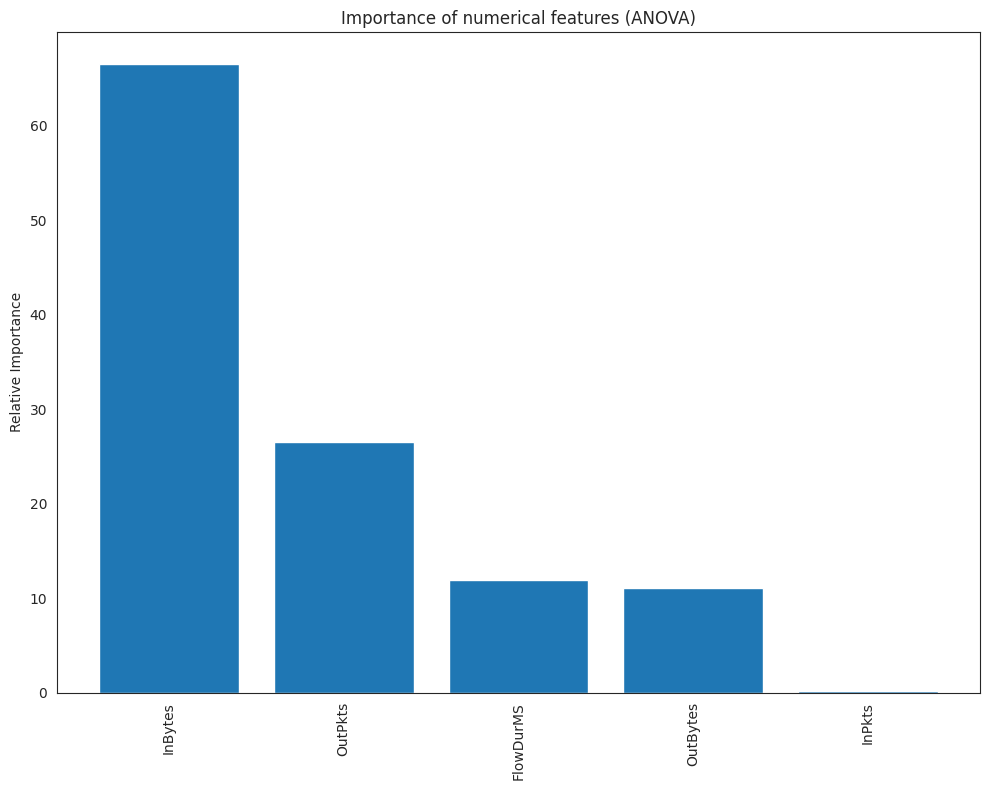

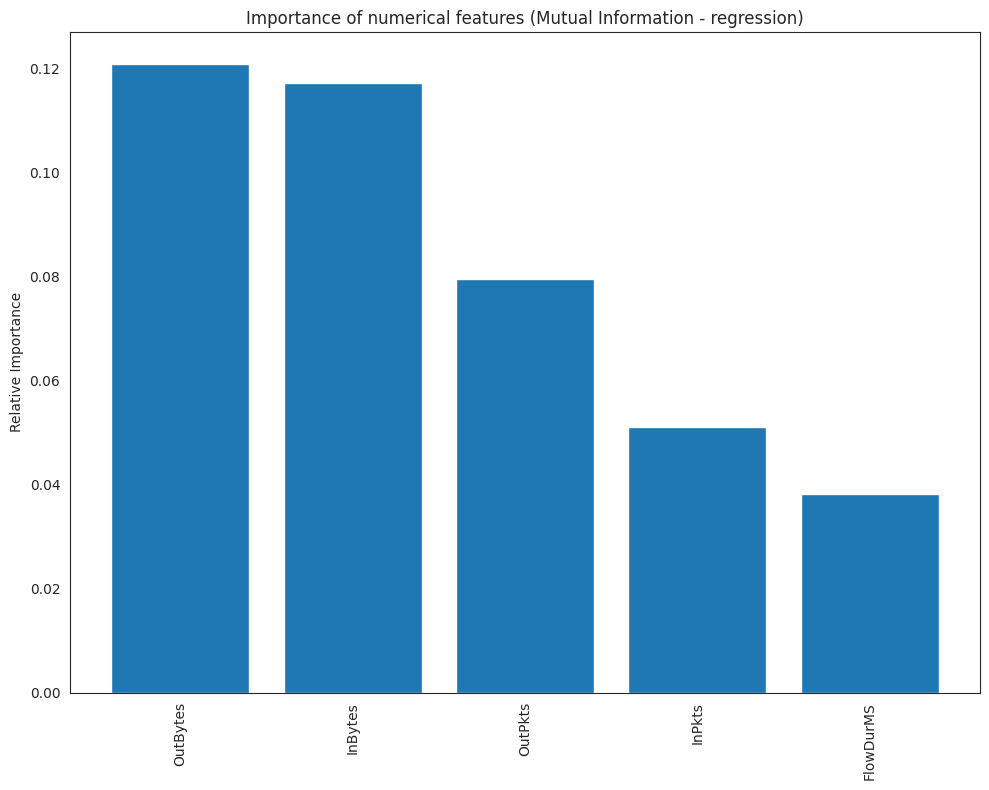

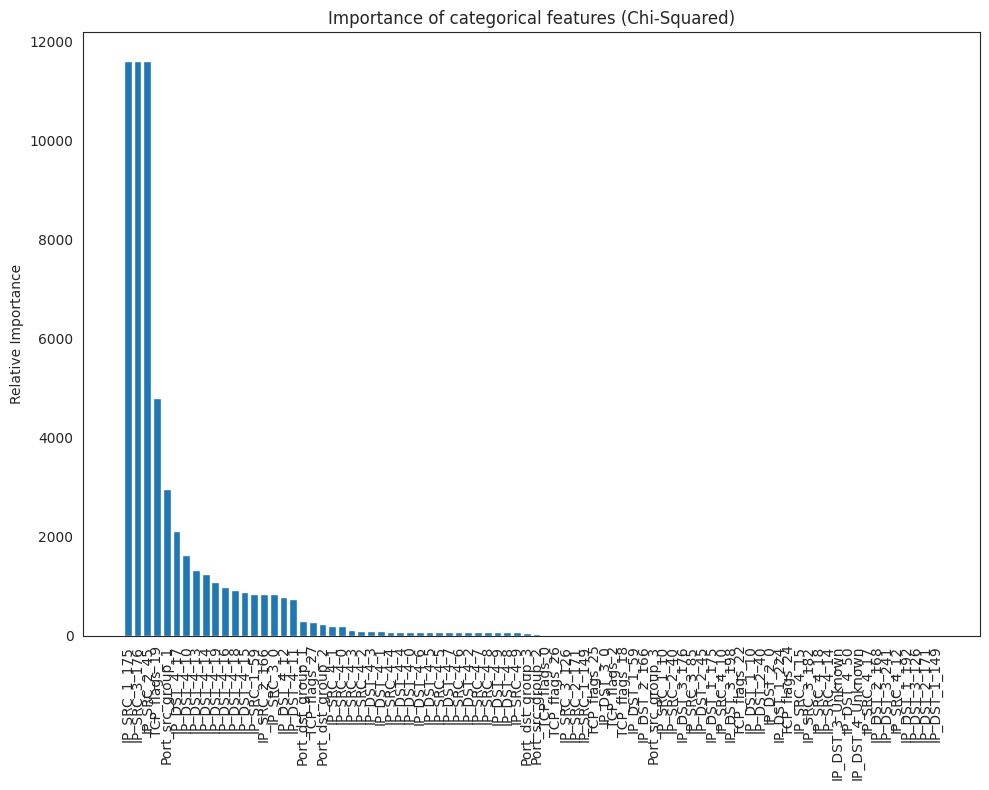

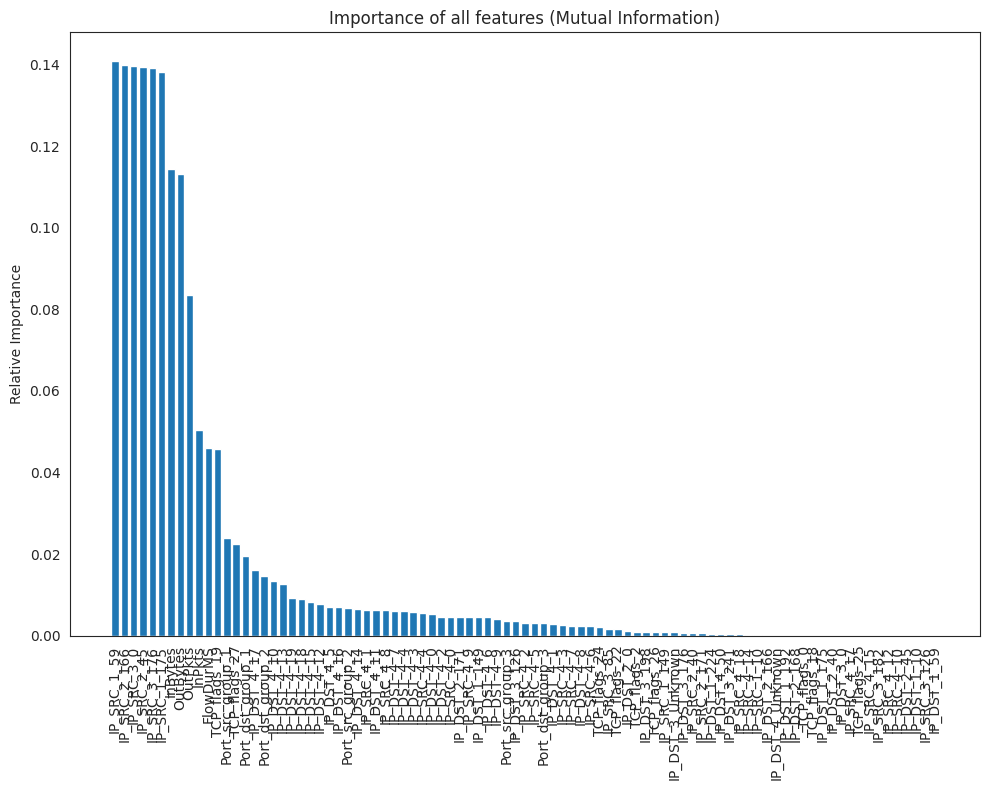

In [ ]:
# Define a function to get feature scores
def get_feature_scores(X_train, y_train, score_func):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    return fs.scores_

def plot_feature_scores(features, scores, title):
    # Plotting feature importances
    plt.figure(figsize=(10,8))
    indices = np.argsort(scores)[::-1]  # reverse to plot highest scores at the top
    plt.title(title)
    plt.bar(range(len(indices)), scores[indices], align='center')
    plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)  # rotate x-axis labels for better visibility
    plt.ylabel('Relative Importance')
    plt.tight_layout()  # Adjust layout for better visibility of x-axis labels
    plt.show()

# Get feature scores
f_classif_scores = get_feature_scores(X_train_final_num, Y_train, f_classif)
mutual_info_reg_scores = get_feature_scores(X_train_final_num, Y_train, mutual_info_regression)
mutual_info_classif_scores = get_feature_scores(X_train_final, Y_train, mutual_info_classif)
chi2_scores, _ = chi2(X_train_final_cat, Y_train)

# Plot importances for numerical features using ANOVA
plot_feature_scores(X_train_final_num.columns, f_classif_scores, 'Importance of numerical features (ANOVA)')

# Plot importances for numerical features using Mutual Information
plot_feature_scores(X_train_final_num.columns, mutual_info_reg_scores, 'Importance of numerical features (Mutual Information - regression)')

# Plot importances for categorical features using Chi-Squared test
plot_feature_scores(X_train_final_cat.columns, chi2_scores, 'Importance of categorical features (Chi-Squared)')

# Plot importances for all features using Mutual Information
plot_feature_scores(X_train_final.columns, mutual_info_classif_scores, 'Importance of all features (Mutual Information)')



# Initial test for RFE on numerical values

NOTE: This is to atest see how the output turns out and whether it is useful.

Number of features: 1, Selected features: ['InBytes']
>1 0.595 (0.155)
Number of features: 2, Selected features: ['InBytes', 'FlowDurMS']
>2 0.717 (0.035)
Number of features: 3, Selected features: ['InBytes', 'OutPkts', 'FlowDurMS']
>3 0.791 (0.014)
Number of features: 4, Selected features: ['InBytes', 'OutBytes', 'OutPkts', 'FlowDurMS']
>4 0.810 (0.017)
Number of features: 5, Selected features: ['InBytes', 'OutBytes', 'InPkts', 'OutPkts', 'FlowDurMS']
>5 0.818 (0.015)


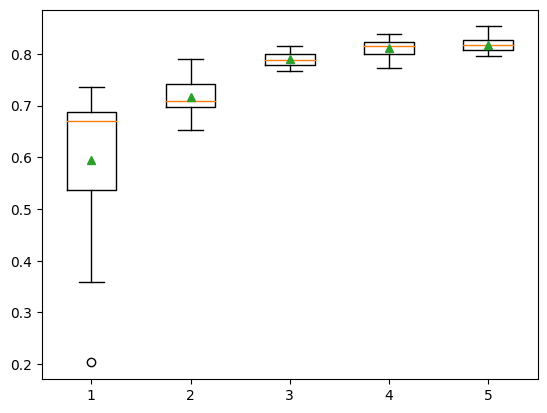

In [ ]:
# As numerical and categorical features, are separated, we concatenate them together.
feature_names = list(X_train_final_num.columns)# + list(X_train_final_cat.columns)

# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1, len(feature_names) + 1):
        rfe = RFE(estimator=DecisionTreeClassifier(criterion='entropy', random_state=42), n_features_to_select=i)
        #model = DecisionTreeClassifier()
        model = RandomForestClassifier(random_state=42, n_jobs=-1) # One can try this if computation allows for it. If not, the line above can take its place
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, Y, scoring='f1', cv=cv, n_jobs=-1)
    return scores

# Combine the final preprocessed training dataframes
#X_final_train = pd.concat([X_train_final_num, X_train_final_cat], axis=1)

X_final_train = X_train_final_num


# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    model.fit(X_final_train, Y_train)  # fit model to get feature importances
    rfe = model.named_steps['s']  # access the RFE step
    selected_features = [x for x, y in zip(feature_names, rfe.support_) if y]  # get names of selected features
    print(f'Number of features: {name}, Selected features: {selected_features}')
    scores = evaluate_model(model, X_final_train, Y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()


# Feature selection on all features

>1 0.792 (0.013)
Number of features: 1, Selected features: ['IP_SRC_1_175']
>2 0.800 (0.017)
Number of features: 2, Selected features: ['InBytes', 'IP_SRC_1_175']
>3 0.825 (0.021)
Number of features: 3, Selected features: ['InBytes', 'OutBytes', 'IP_SRC_1_175']
>4 0.839 (0.016)
Number of features: 4, Selected features: ['InBytes', 'OutBytes', 'FlowDurMS', 'IP_SRC_1_175']
>5 0.840 (0.015)
Number of features: 5, Selected features: ['InBytes', 'OutBytes', 'FlowDurMS', 'IP_SRC_1_175', 'Port_src_group_1']
>6 0.837 (0.018)
Number of features: 6, Selected features: ['InBytes', 'OutBytes', 'FlowDurMS', 'TCP_flags_18', 'IP_SRC_1_175', 'Port_src_group_1']
>7 0.844 (0.014)
Number of features: 7, Selected features: ['InBytes', 'OutBytes', 'InPkts', 'FlowDurMS', 'TCP_flags_18', 'IP_SRC_1_175', 'Port_src_group_1']
>8 0.844 (0.017)
Number of features: 8, Selected features: ['InBytes', 'OutBytes', 'InPkts', 'FlowDurMS', 'TCP_flags_18', 'IP_SRC_2_45', 'IP_SRC_4_2', 'Port_src_group_1']
>9 0.843 (0.019)


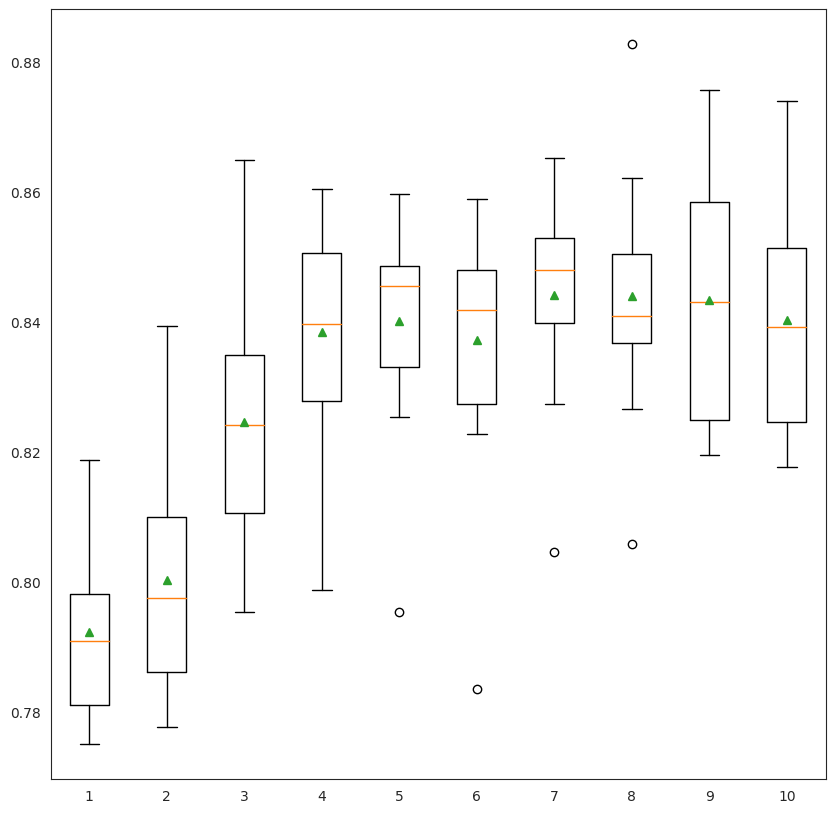

In [ ]:
# As numerical and categorical features, are separated, we concatenate them together.
feature_names = list(X_train_final_num.columns) + list(X_train_final_cat.columns)

# get a list of models to evaluate
def get_models():
    models = dict()
    # Define the step size for features to be tested
    step = 1
    max_features = 10
    for i in range(step, max_features + 1, step):
        rfe = RFE(estimator=DecisionTreeClassifier(criterion='entropy', random_state=42), n_features_to_select=i)
        #model = DecisionTreeClassifier()
        model = RandomForestClassifier(random_state=42, n_jobs=-1) # One can try this if computation allows for it. If not, the line above can take its place
        models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_validate(model, X, Y, scoring='f1', cv=cv, n_jobs=-1, return_estimator=True)
    return scores

# Combine the final preprocessed training dataframes
X_final_train = pd.concat([X_train_final_num, X_train_final_cat], axis=1)

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    cv_results = evaluate_model(model, X_final_train, Y_train)
    # scores are now stored in 'test_score' key as cross_validate was used instead of cross_val_score
    scores = cv_results['test_score']
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

    # get the best model from cross-validation
    best_model_index = scores.argmax()
    best_model = cv_results['estimator'][best_model_index]
    # Access the RFE step to get the selected features after the model has been fitted
    rfe = best_model.named_steps['s']
    selected_features = [x for x, y in zip(feature_names, rfe.support_) if y]
    print(f'Number of features: {name}, Selected features: {selected_features}')

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()


# MACHINE LEARNING MODELS - full dataset

### First get the selected features

In [ ]:
X_train_final.columns

Index(['InBytes', 'OutBytes', 'InPkts', 'OutPkts', 'FlowDurMS', 'TCP_flags_0',
       'TCP_flags_18', 'TCP_flags_19', 'TCP_flags_2', 'TCP_flags_22',
       'TCP_flags_24', 'TCP_flags_25', 'TCP_flags_26', 'TCP_flags_27',
       'IP_SRC_1_10', 'IP_SRC_1_149', 'IP_SRC_1_175', 'IP_SRC_1_59',
       'IP_SRC_2_166', 'IP_SRC_2_171', 'IP_SRC_2_40', 'IP_SRC_2_45',
       'IP_SRC_3_0', 'IP_SRC_3_126', 'IP_SRC_3_176', 'IP_SRC_3_182',
       'IP_SRC_3_85', 'IP_SRC_4_0', 'IP_SRC_4_1', 'IP_SRC_4_10', 'IP_SRC_4_12',
       'IP_SRC_4_14', 'IP_SRC_4_15', 'IP_SRC_4_17', 'IP_SRC_4_18',
       'IP_SRC_4_2', 'IP_SRC_4_3', 'IP_SRC_4_4', 'IP_SRC_4_5', 'IP_SRC_4_6',
       'IP_SRC_4_7', 'IP_SRC_4_8', 'IP_SRC_4_9', 'IP_DST_1_10', 'IP_DST_1_149',
       'IP_DST_1_175', 'IP_DST_1_192', 'IP_DST_1_224', 'IP_DST_1_59',
       'IP_DST_2_0', 'IP_DST_2_166', 'IP_DST_2_168', 'IP_DST_2_171',
       'IP_DST_2_40', 'IP_DST_2_45', 'IP_DST_3_0', 'IP_DST_3_126',
       'IP_DST_3_176', 'IP_DST_3_198', 'IP_DST_3_241', 'IP_DST_

In [ ]:
X_selected_train_anochi = X_train_final[['IP_SRC_1_175', 'IP_SRC_2_45', 'IP_SRC_3_176', 'TCP_flags_19', 'OutPkts', 'InBytes']]
X_selected_train_mutual = X_train_final[['IP_SRC_3_0', 'IP_SRC_2_166', 'IP_SRC_1_59', 'IP_DST_2_171', 'IP_DST_1_149', 'IP_DST_3_126', 'TCP_flags_27', 'Port_src_group_2', 'Port_dst_group_1']]
X_selected_train_DT = X_train_final[['InBytes', 'OutBytes', 'InPkts', 'FlowDurMS', 'TCP_flags_18', 'IP_SRC_1_175', 'Port_src_group_1']]

X_selected_test_anochi = X_test_final[['IP_SRC_1_175', 'IP_SRC_2_45', 'IP_SRC_3_176', 'TCP_flags_19', 'OutPkts', 'InBytes']]
X_selected_test_mutual = X_test_final[['IP_SRC_3_0', 'IP_SRC_2_166', 'IP_SRC_1_59', 'IP_DST_2_171', 'IP_DST_1_149', 'IP_DST_3_126', 'TCP_flags_27', 'Port_src_group_2', 'Port_dst_group_1']]
X_selected_test_DT = X_test_final[['InBytes', 'OutBytes', 'InPkts', 'FlowDurMS', 'TCP_flags_18', 'IP_SRC_1_175', 'Port_src_group_1']]

#X_selected_train_DT = X_train_final[['IP_SRC_1_175', 'Port_src_group_1', 'Port_dst_group_1']]
#X_selected_test_DT = X_test_final[['IP_SRC_1_175', 'Port_src_group_1', 'Port_dst_group_1']]
# For practical purposes I will use this variable for all. Easier to change here than all the variables


model_performance = pd.DataFrame(columns=['Recall','Precision','F1-Score','time to train','time to predict','total time'])



Feature Set 1:
Precision: 98.30%
Recall: 98.32%
F1-Score: 98.31%
time to train: 0.03 s
time to predict: 0.19 s
total: 0.22 s


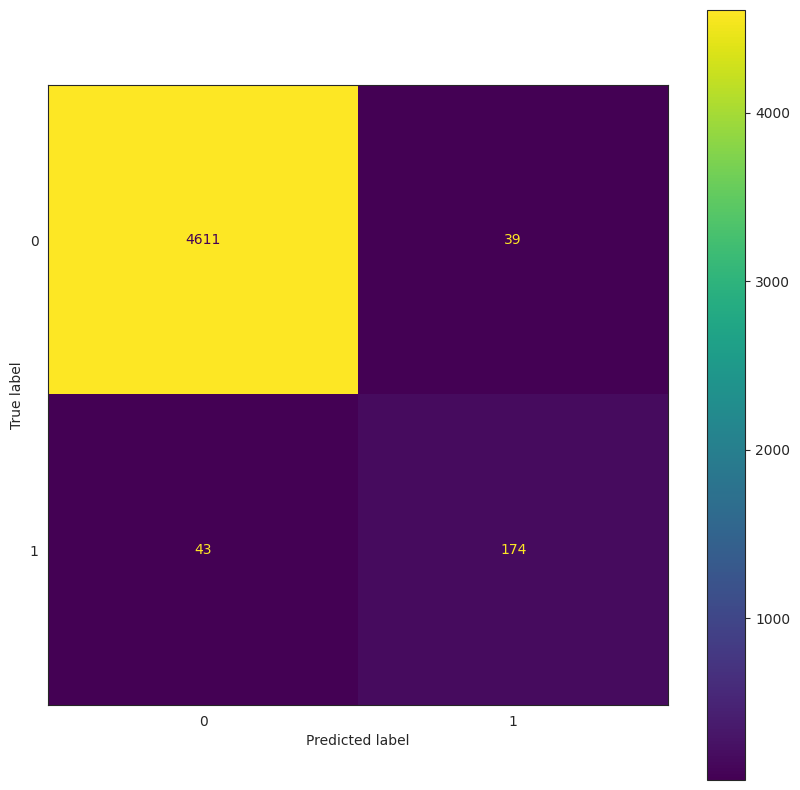

Feature Set 2:
Precision: 98.33%
Recall: 97.72%
F1-Score: 97.91%
time to train: 0.03 s
time to predict: 0.84 s
total: 0.87 s


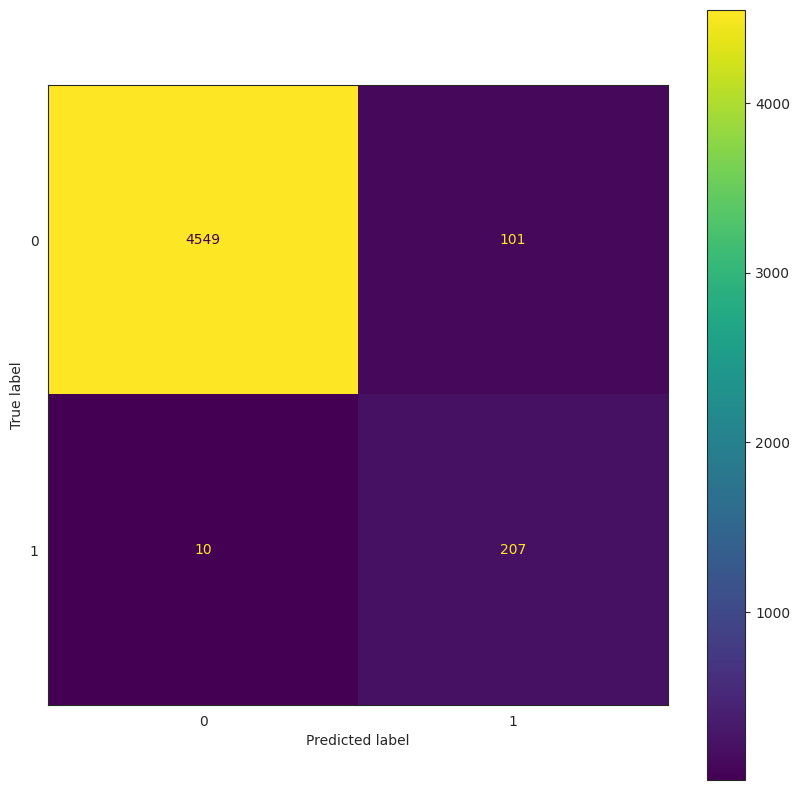

Feature Set 3:
Precision: 97.71%
Recall: 97.80%
F1-Score: 97.75%
time to train: 0.02 s
time to predict: 0.16 s
total: 0.18 s


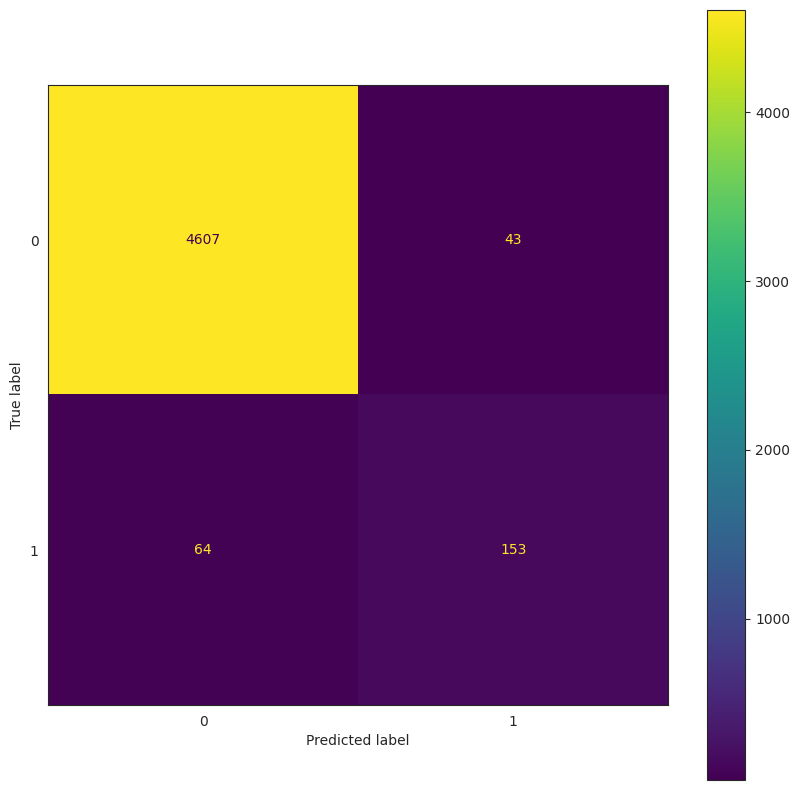

In [ ]:
feature_sets = [X_selected_train_anochi, X_selected_train_mutual, X_selected_train_DT]  # You can add all your feature sets here.
feature_sets_test = [X_selected_test_anochi, X_selected_test_mutual, X_selected_test_DT]  # Corresponding test sets.

for idx, (X_train_set, X_test_set) in enumerate(zip(feature_sets, feature_sets_test)):
    start = time.time()
    model = KNeighborsClassifier(n_neighbors=5)
    model = model.fit(X_train_set, Y_train)
    end_train = time.time()
    Y_predictions = model.predict(X_test_set)
    end_predict = time.time()

    recall = recall_score(Y_test, Y_predictions, average='weighted')
    precision = precision_score(Y_test, Y_predictions, average='weighted')
    f1s = f1_score(Y_test, Y_predictions, average='weighted')

    print(f"Feature Set {idx + 1}:")
    print("Precision: "+ "{:.2%}".format(precision))
    print("Recall: "+ "{:.2%}".format(recall))
    print("F1-Score: "+ "{:.2%}".format(f1s))
    print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
    print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
    print("total: "+"{:.2f}".format(end_predict-start)+" s")

    model_performance.loc[f'KNeighbors - Feature Set {idx + 1}'] = [recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

    cm = confusion_matrix(Y_test, Y_predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format = '.0f')
    plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precision: 91.40%
Recall: 87.69%
F1-Score: 89.48%
time to train: 0.63 s
time to predict: 0.00 s
total: 0.63 s


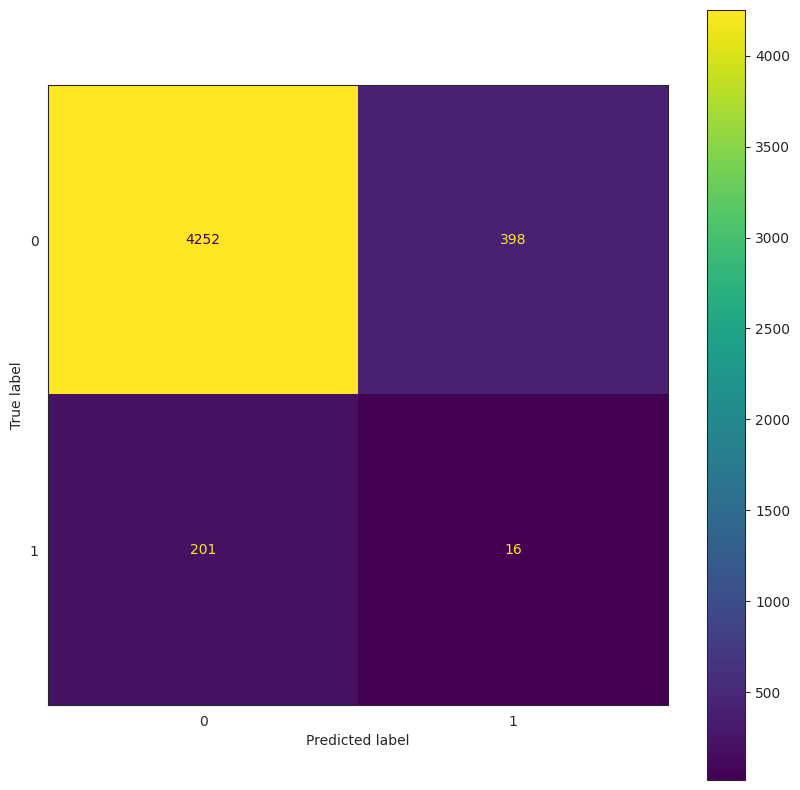

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precision: 95.79%
Recall: 25.58%
F1-Score: 35.07%
time to train: 0.65 s
time to predict: 0.01 s
total: 0.66 s


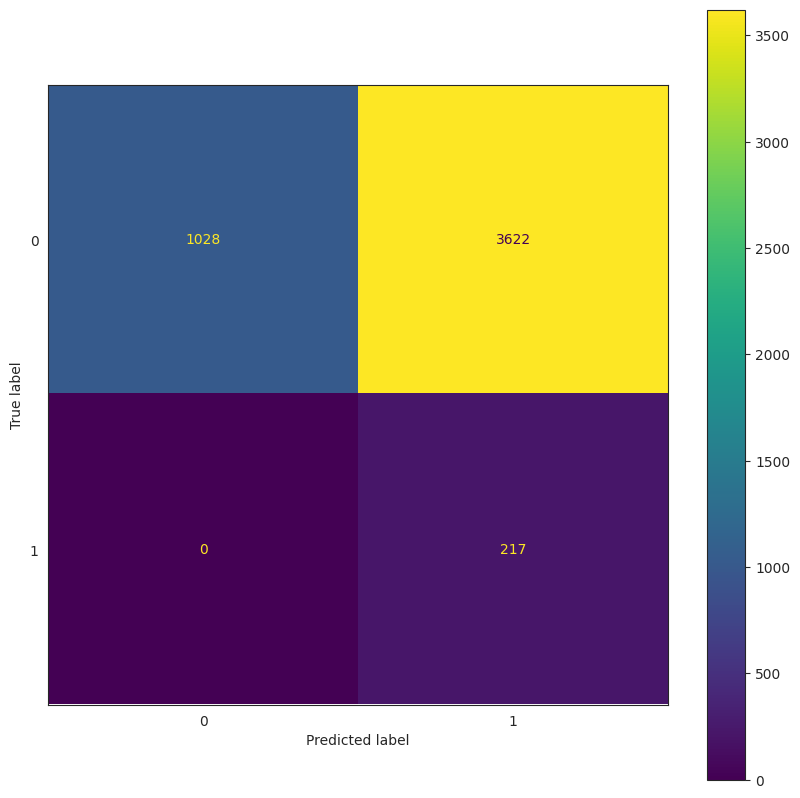

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precision: 91.69%
Recall: 94.23%
F1-Score: 92.88%
time to train: 0.28 s
time to predict: 0.02 s
total: 0.30 s


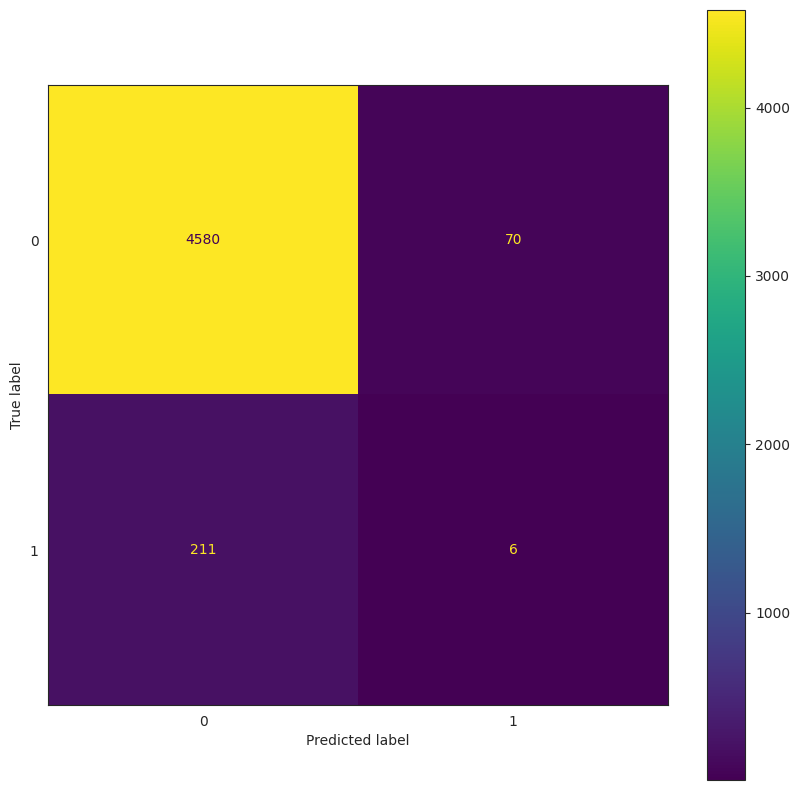

In [ ]:
#KMeans model

for idx, (X_train_set, X_test_set) in enumerate(zip(feature_sets, feature_sets_test)):
    start = time.time()
    model = KMeans(n_clusters = 4, random_state=53) # Randomly chosen
    model.fit(X_train_set)
    end_train = time.time()
    Y_predictions = model.predict(X_test_set)
    end_predict = time.time()

    # Assume that the cluster 0 in KMeans corresponds to class 0 in Y_test, and cluster 1 corresponds to class 1
    # If this is not the case, you may need to swap the predictions
    Y_predictions_swapped = np.where(Y_predictions==0, 0, 1)

    recall = recall_score(Y_test, Y_predictions_swapped, average='weighted')
    precision = precision_score(Y_test, Y_predictions_swapped, average='weighted')
    f1s = f1_score(Y_test, Y_predictions_swapped, average='weighted')

    print("Precision: "+ "{:.2%}".format(precision))
    print("Recall: "+ "{:.2%}".format(recall))
    print("F1-Score: "+ "{:.2%}".format(f1s))
    print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
    print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
    print("total: "+"{:.2f}".format(end_predict-start)+" s")

    model_performance.loc[f'KMeans - Feature Set {idx + 1}'] = [recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

    cm = confusion_matrix(Y_test, Y_predictions_swapped)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format = '.0f')
    plt.show()

Feature Set 1:
Precision: 98.48%
Recall: 98.52%
F1-Score: 98.50%
time to train: 2.07 s
time to predict: 0.23 s
total: 2.30 s


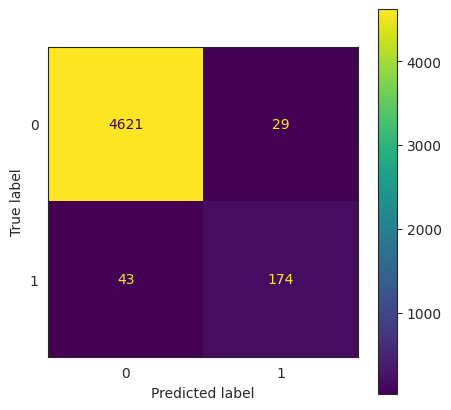

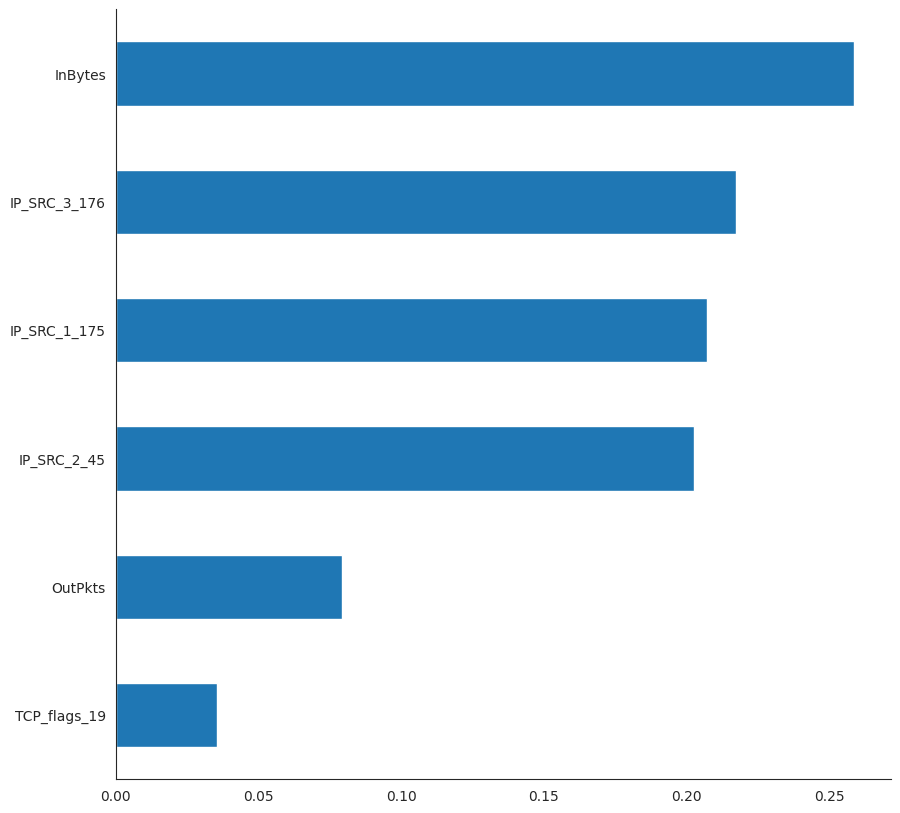

Feature Set 2:
Precision: 98.33%
Recall: 97.72%
F1-Score: 97.91%
time to train: 2.88 s
time to predict: 0.29 s
total: 3.17 s


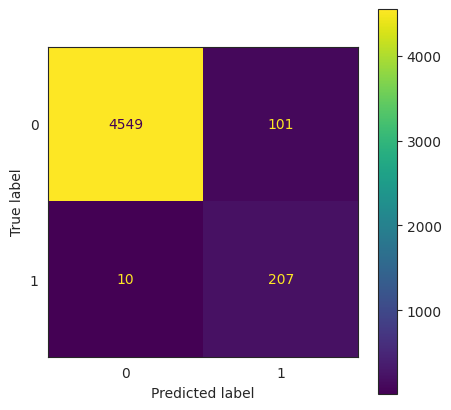

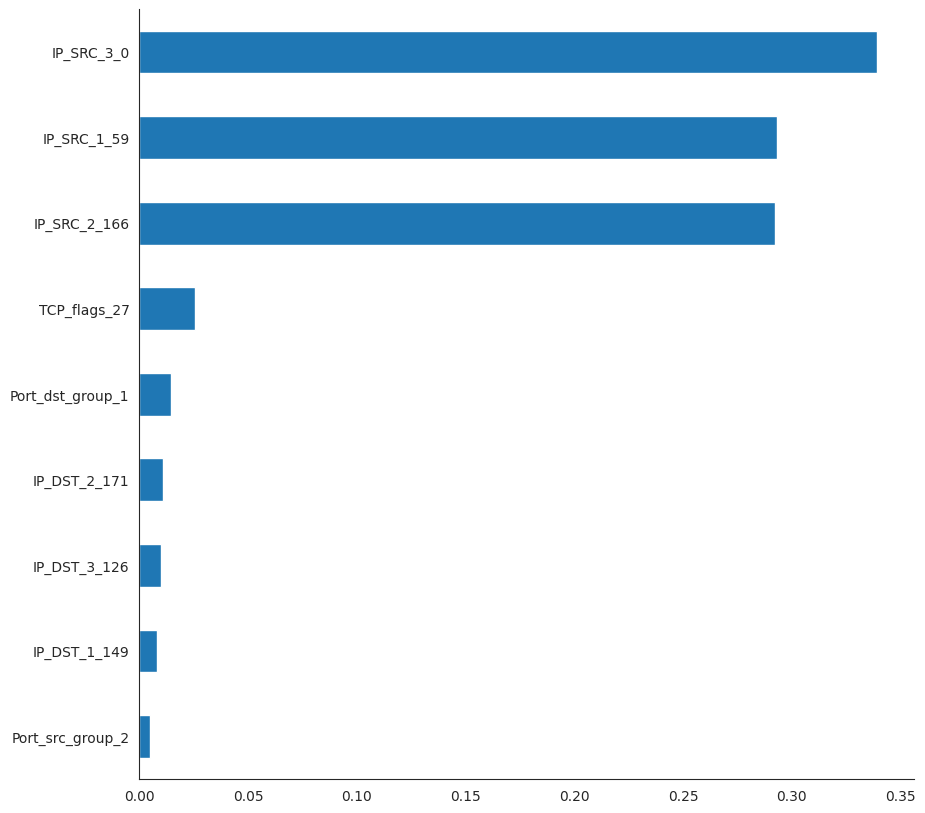

Feature Set 3:
Precision: 98.55%
Recall: 98.56%
F1-Score: 98.56%
time to train: 2.75 s
time to predict: 0.23 s
total: 2.98 s


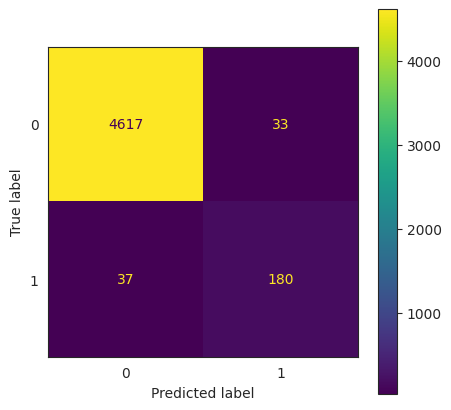

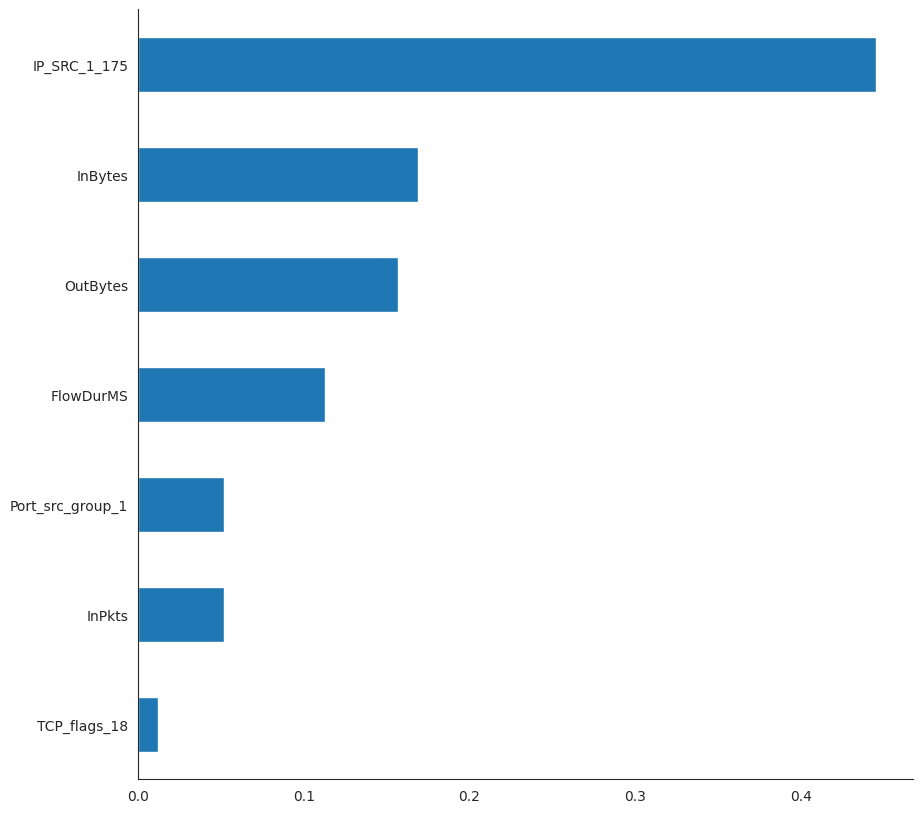

In [ ]:
# Random Forest

for idx, (X_train_set, X_test_set) in enumerate(zip(feature_sets, feature_sets_test)):
    start = time.time()
    model = RandomForestClassifier(n_estimators = 500, n_jobs=-1, random_state=53, bootstrap=True)
    model = model.fit(X_train_set, Y_train)
    end_train = time.time()
    Y_predictions = model.predict(X_test_set)
    end_predict = time.time()

    recall = recall_score(Y_test, Y_predictions, average='weighted')
    precision = precision_score(Y_test, Y_predictions, average='weighted')
    f1s = f1_score(Y_test, Y_predictions, average='weighted')

    print(f"Feature Set {idx + 1}:")
    print("Precision: "+ "{:.2%}".format(precision))
    print("Recall: "+ "{:.2%}".format(recall))
    print("F1-Score: "+ "{:.2%}".format(f1s))
    print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
    print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
    print("total: "+"{:.2f}".format(end_predict-start)+" s")

    model_performance.loc[f'Random Forest - Feature Set {idx + 1}'] = [recall, precision, f1s, end_train-start, end_predict-end_train, end_predict-start]

    plt.rcParams['figure.figsize'] = 5, 5
    sns.set_style("white")

    cm = confusion_matrix(Y_test, Y_predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format = '.0f')
    plt.show()

    feature_names = list(X_train_set.columns)
    plt.rcParams['figure.figsize'] = 10, 10
    sns.set_style("white")
    feat_importances = pd.Series(model.feature_importances_, index=feature_names)
    feat_importances = feat_importances.groupby(level=0).mean()
    feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
    sns.despine()
    plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Feature Set 1:
Precision: 98.53%
Recall: 98.54%
F1-Score: 98.54%
time to train: 0.86 s
time to predict: 0.01 s
total: 0.87 s


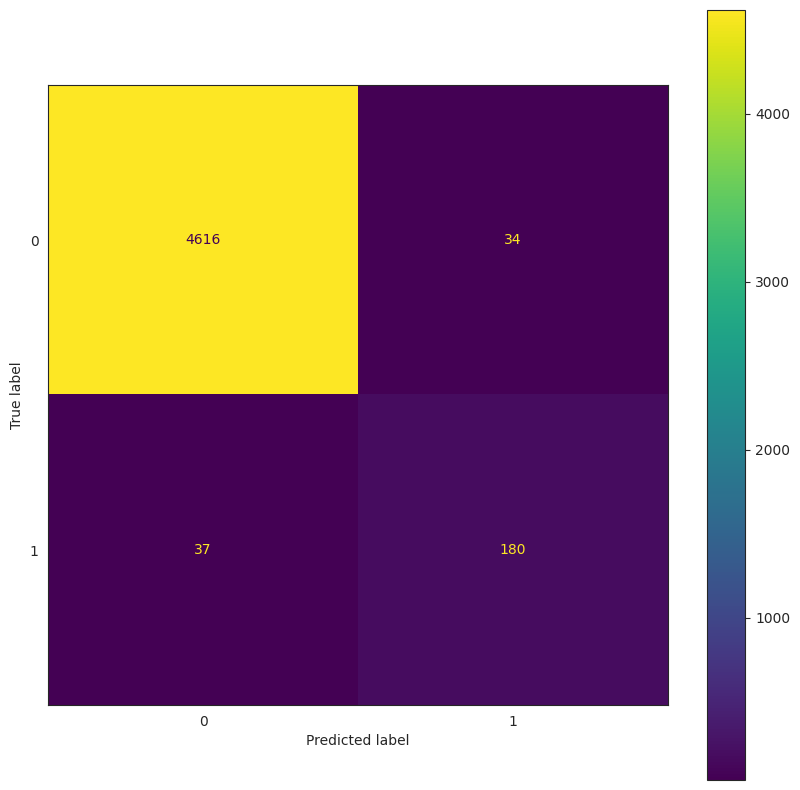

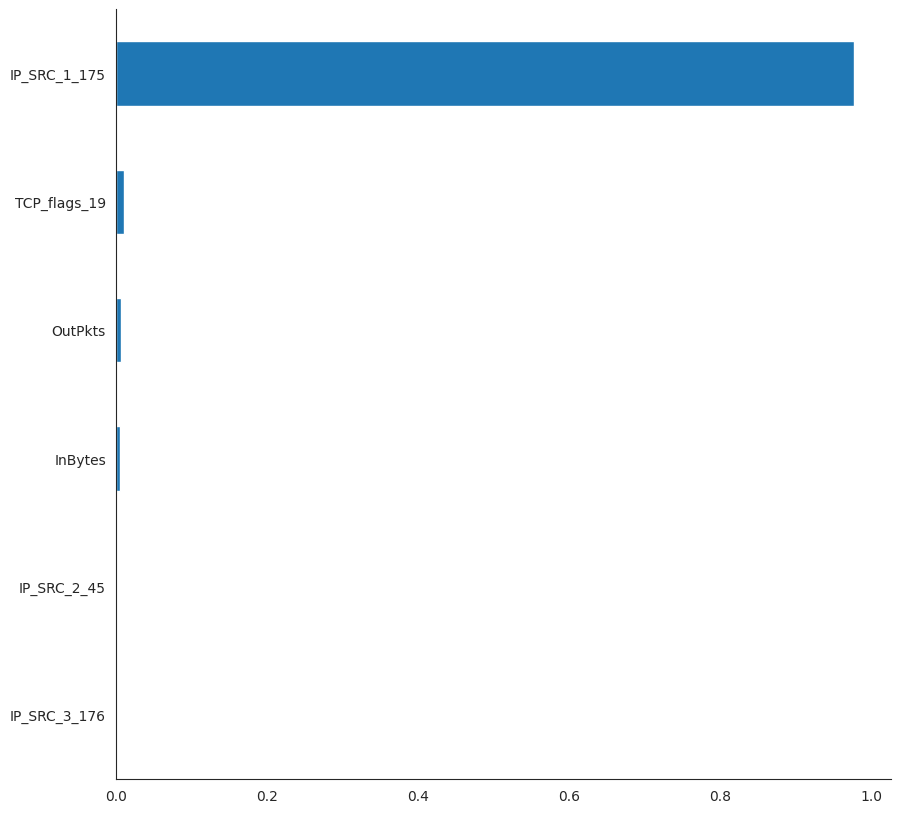

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Feature Set 2:
Precision: 98.33%
Recall: 97.72%
F1-Score: 97.91%
time to train: 0.70 s
time to predict: 0.01 s
total: 0.70 s


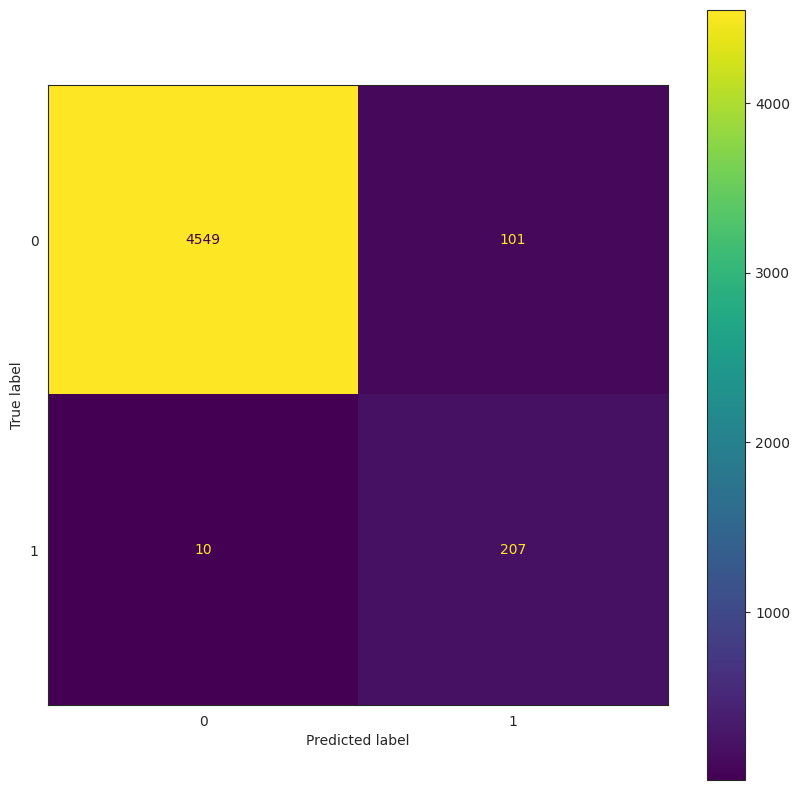

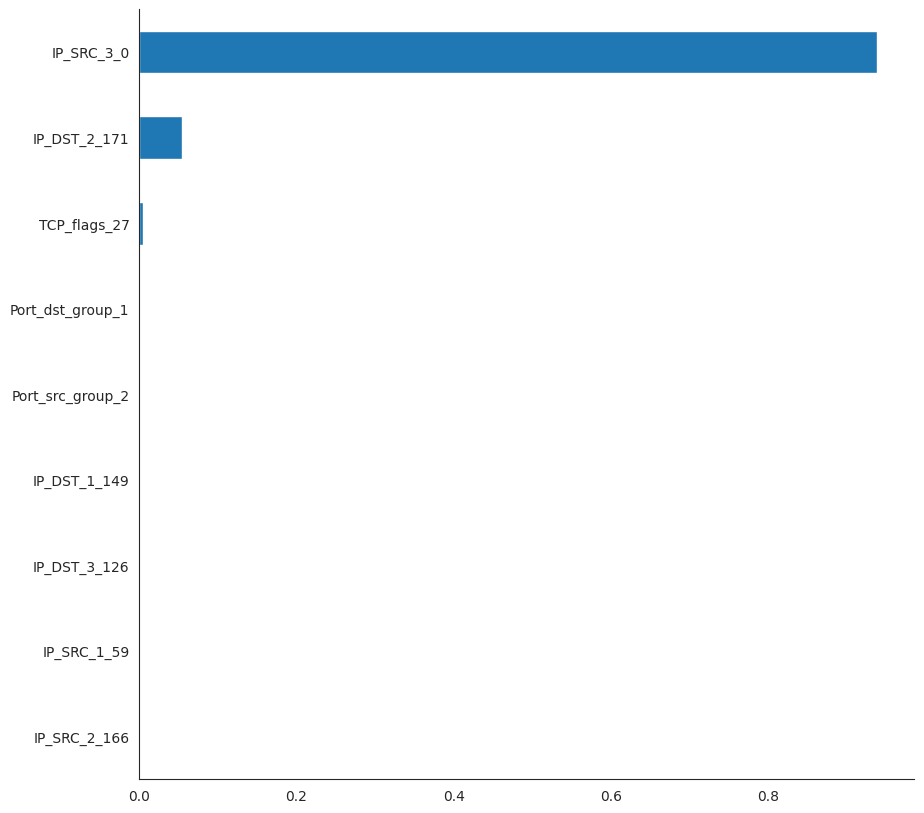

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Feature Set 3:
Precision: 98.65%
Recall: 98.66%
F1-Score: 98.65%
time to train: 3.19 s
time to predict: 0.01 s
total: 3.20 s


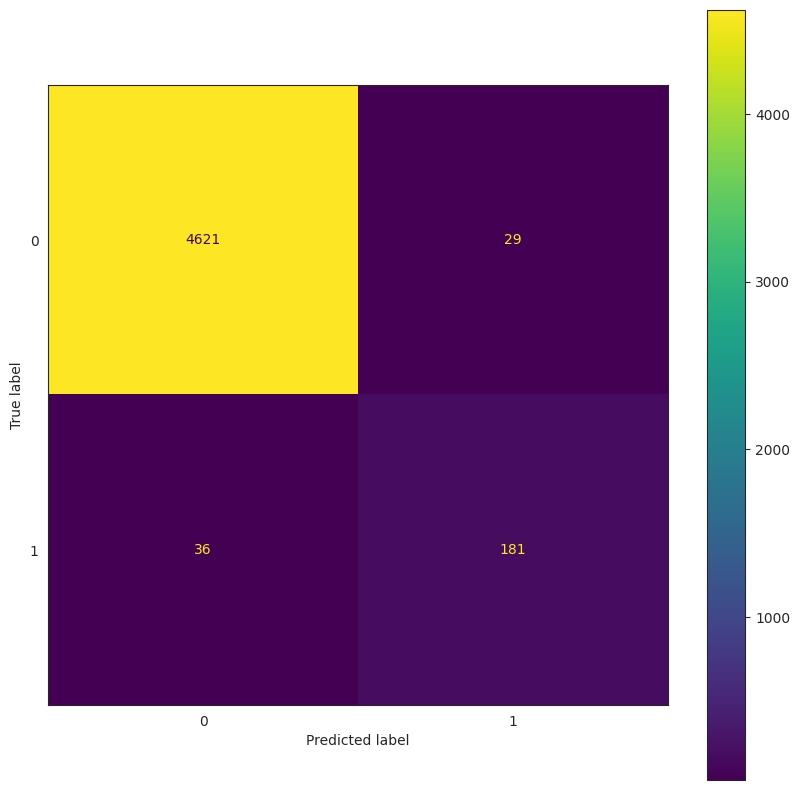

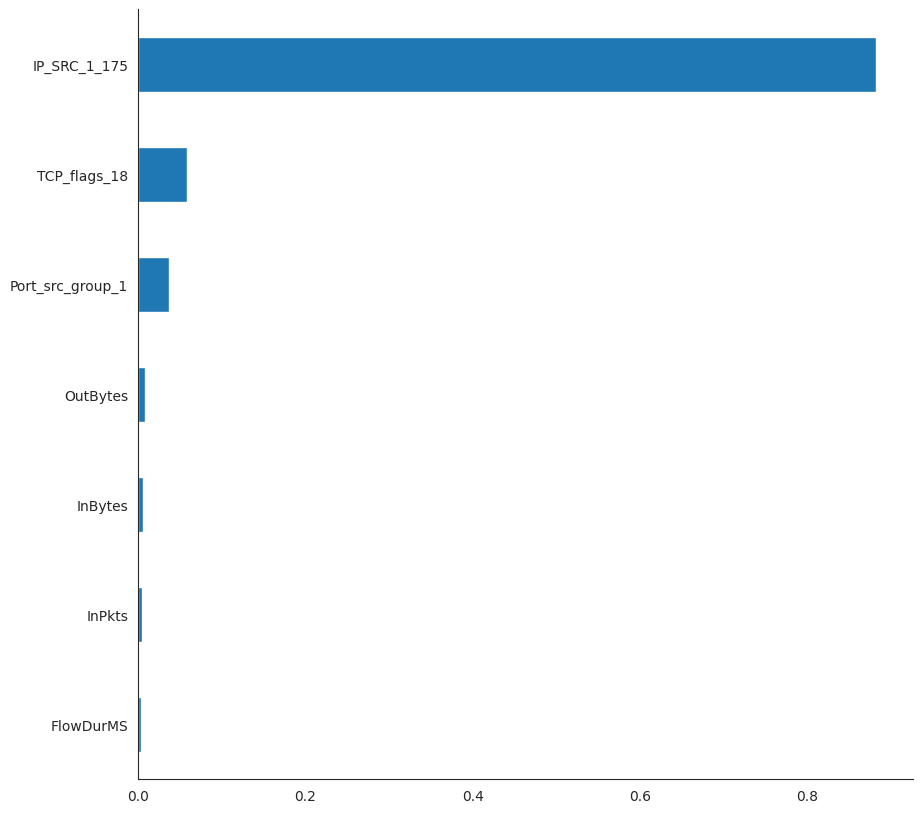

In [ ]:
#XGBOOST

for idx, (X_train_set, X_test_set) in enumerate(zip(feature_sets, feature_sets_test)):
    start = time.time()
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model = model.fit(X_train_set, Y_train)
    end_train = time.time()
    Y_predictions = model.predict(X_test_set)
    end_predict = time.time()

    recall = recall_score(Y_test, Y_predictions, average='weighted')
    precision = precision_score(Y_test, Y_predictions, average='weighted')
    f1s = f1_score(Y_test, Y_predictions, average='weighted')

    print(f"Feature Set {idx + 1}:")
    print("Precision: "+ "{:.2%}".format(precision))
    print("Recall: "+ "{:.2%}".format(recall))
    print("F1-Score: "+ "{:.2%}".format(f1s))
    print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
    print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
    print("total: "+"{:.2f}".format(end_predict-start)+" s")

    model_performance.loc[f'XGBoost - Feature Set {idx + 1}'] = [recall, precision, f1s, end_train-start, end_predict-end_train, end_predict-start]

    cm = confusion_matrix(Y_test, Y_predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format = '.0f')
    plt.show()

    feature_names = list(X_train_set.columns)
    feat_importances = pd.Series(model.feature_importances_, index=feature_names)
    feat_importances = feat_importances.groupby(level=0).mean()
    feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
    sns.despine()
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Feature Set 1:
Precision: 95.32%
Recall: 94.95%
F1-Score: 95.12%
time to train: 0.64 s
time to predict: 0.15 s
total: 0.80 s


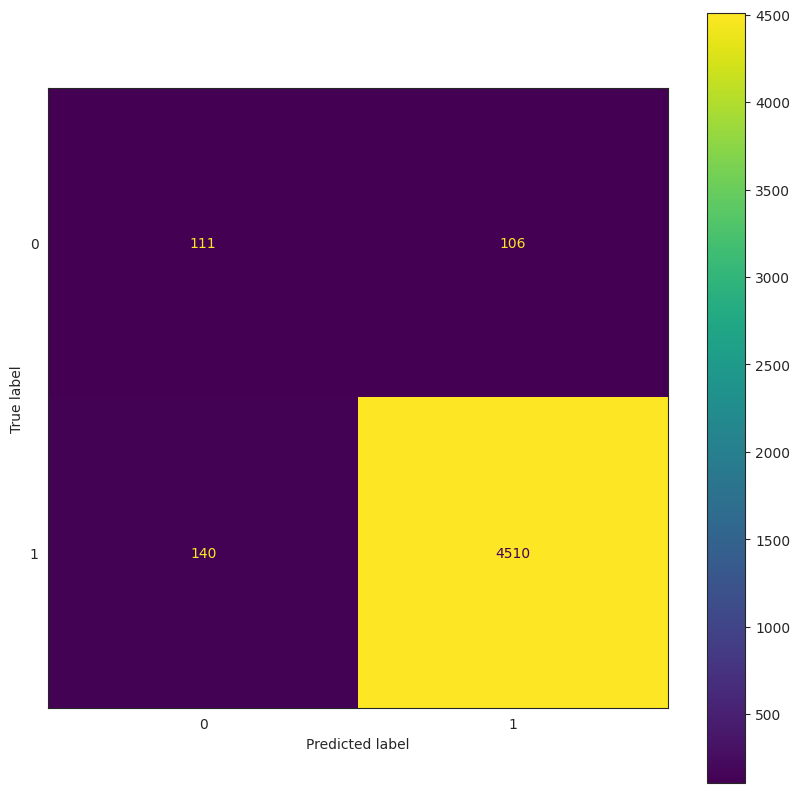

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Feature Set 2:
Precision: 94.85%
Recall: 95.40%
F1-Score: 95.08%
time to train: 0.55 s
time to predict: 0.13 s
total: 0.67 s


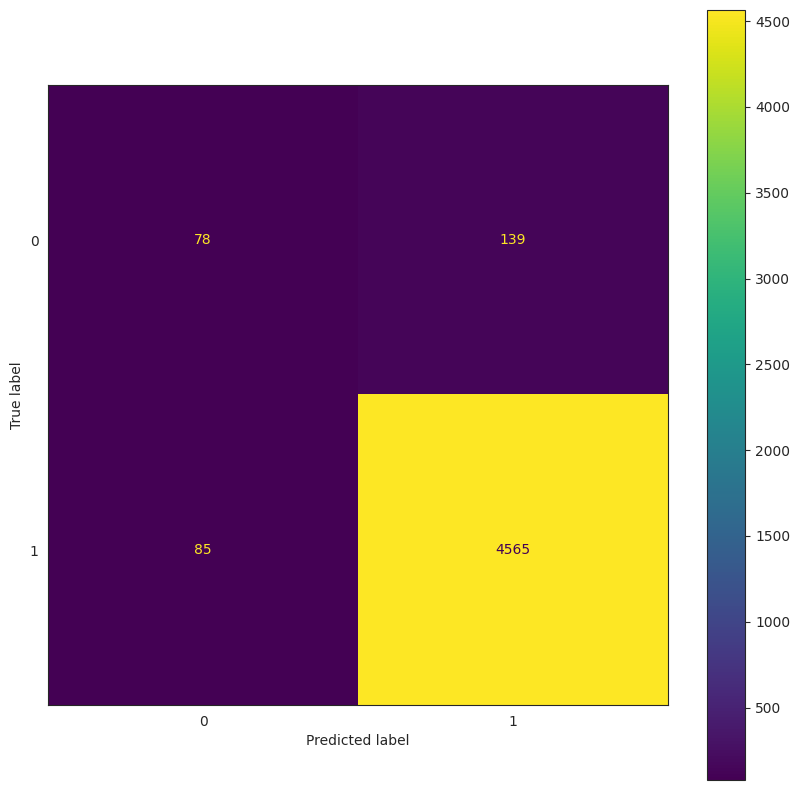

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Feature Set 3:
Precision: 93.27%
Recall: 92.83%
F1-Score: 93.04%
time to train: 0.91 s
time to predict: 0.21 s
total: 1.12 s


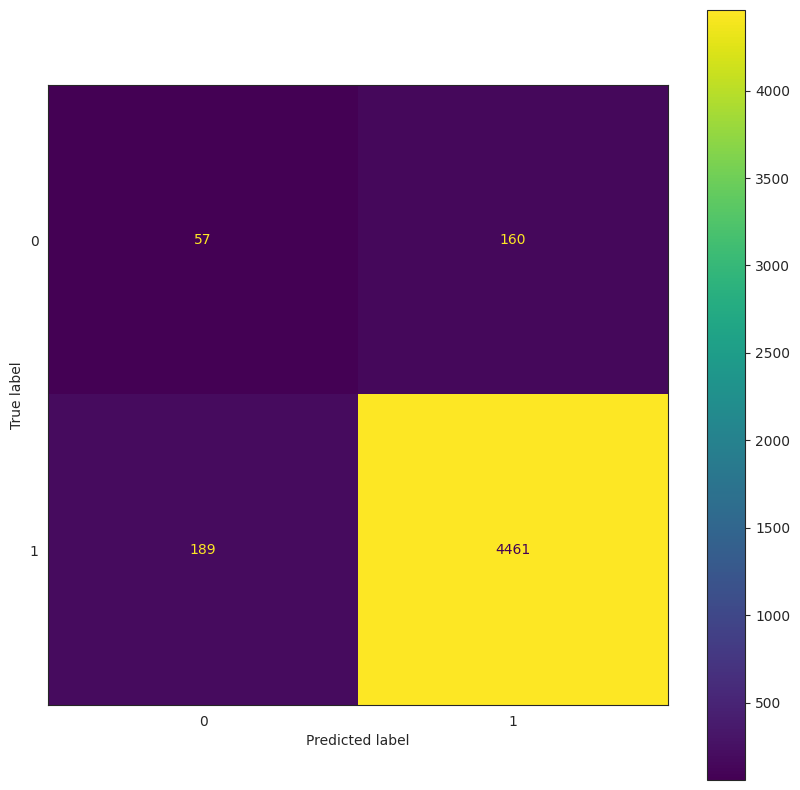

In [ ]:
# Isolation Forest

for idx, (X_train_set, X_test_set) in enumerate(zip(feature_sets, feature_sets_test)):
    start = time.time()
    model = IsolationForest(contamination=0.05, random_state=0)
    model = model.fit(X_train_set)
    end_train = time.time()
    Y_predictions_iso = model.predict(X_test_set)
    end_predict = time.time()

    # Adjusting labels to match the -1 (anomaly) and 1 (normal) convention used by Isolation Forest
    adjusted_Y_test = np.where(Y_test == 0, 1, -1)

    recall = recall_score(adjusted_Y_test, Y_predictions_iso, average='weighted')
    precision = precision_score(adjusted_Y_test, Y_predictions_iso, average='weighted')
    f1s = f1_score(adjusted_Y_test, Y_predictions_iso, average='weighted')

    print(f"Feature Set {idx + 1}:")
    print("Precision: "+ "{:.2%}".format(precision))
    print("Recall: "+ "{:.2%}".format(recall))
    print("F1-Score: "+ "{:.2%}".format(f1s))
    print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
    print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
    print("total: "+"{:.2f}".format(end_predict-start)+" s")

    model_performance.loc[f'Isolation Forest - Feature Set {idx + 1}'] = [recall, precision, f1s, end_train-start, end_predict-end_train, end_predict-start]

    cm = confusion_matrix(adjusted_Y_test, Y_predictions_iso)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format = '.0f')
    plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Feature Set 1:
Precision: 95.32%
Recall: 94.95%
F1-Score: 95.12%
time to train: 0.97 s
time to predict: 0.22 s
total: 1.19 s


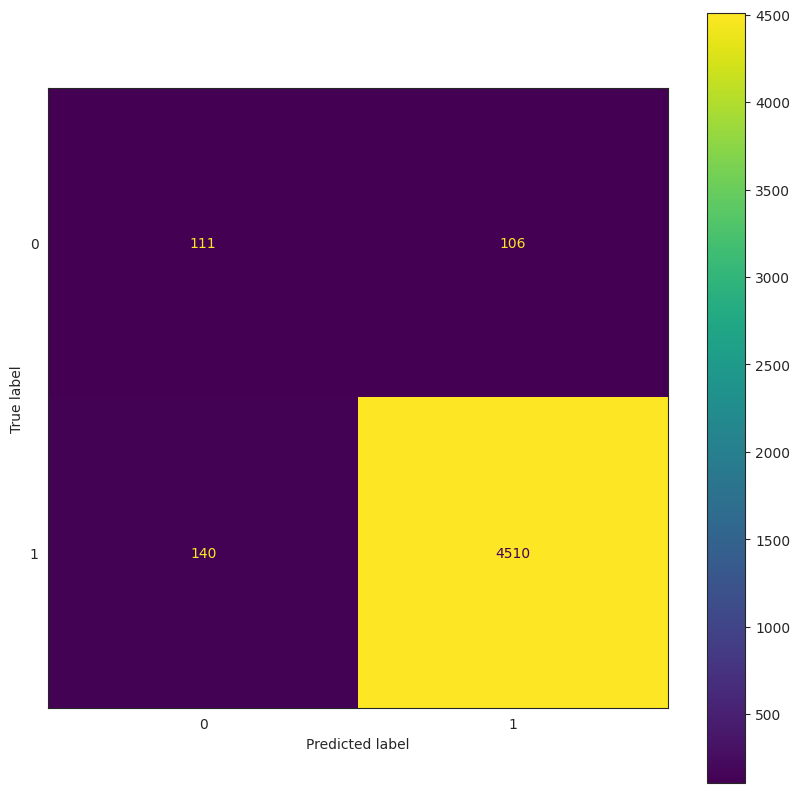

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Feature Set 2:
Precision: 94.85%
Recall: 95.40%
F1-Score: 95.08%
time to train: 0.80 s
time to predict: 0.19 s
total: 0.98 s


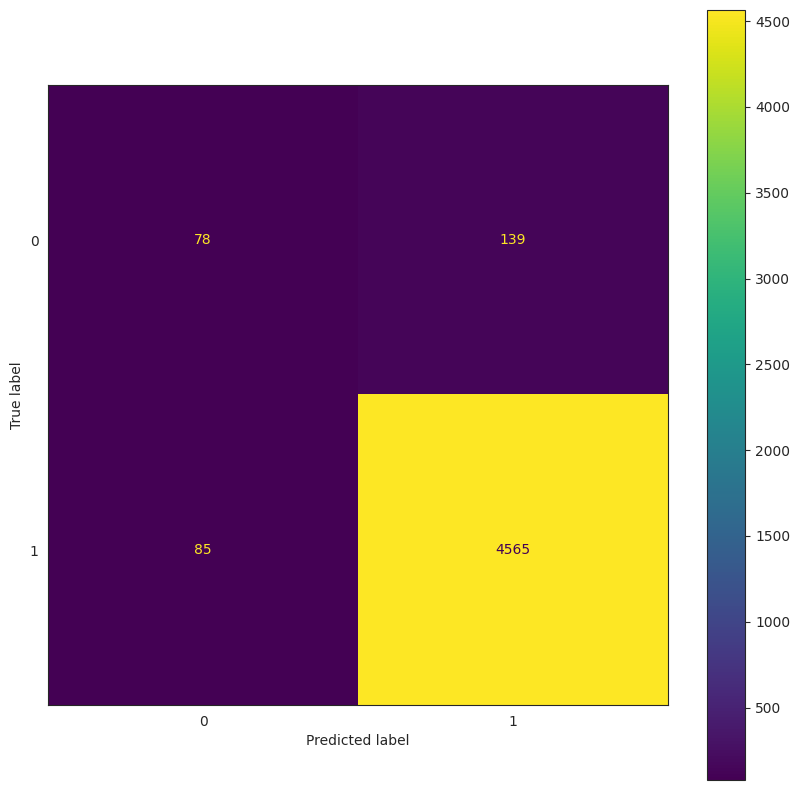

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Feature Set 3:
Precision: 93.27%
Recall: 92.83%
F1-Score: 93.04%
time to train: 0.75 s
time to predict: 0.14 s
total: 0.89 s


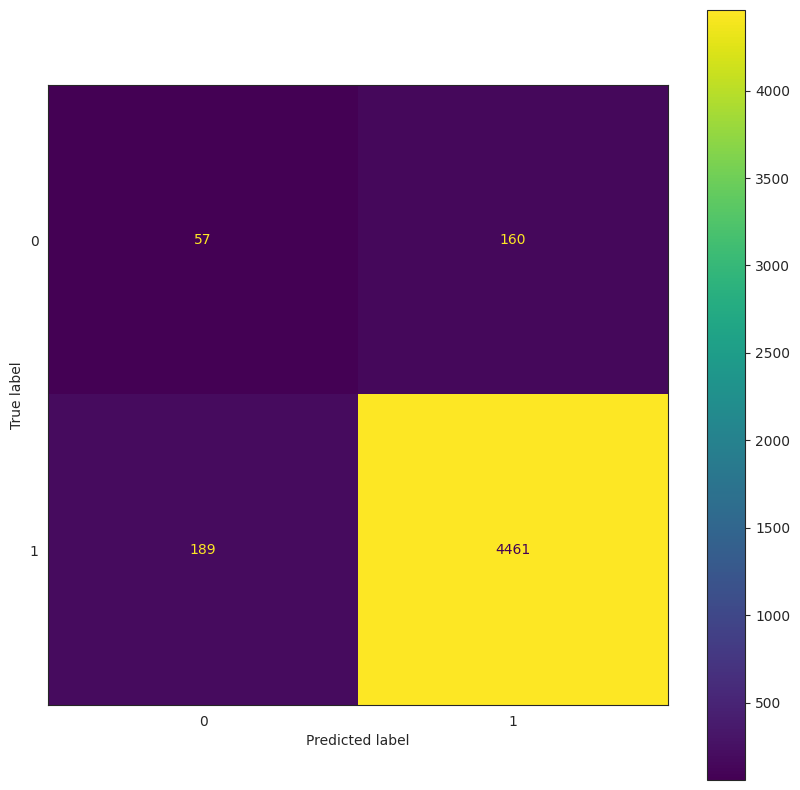

In [ ]:
# Local Outlier Factor
for idx, (X_train_set, X_test_set) in enumerate(zip(feature_sets, feature_sets_test)):
    start = time.time()
    model = IsolationForest(contamination=0.05, random_state=0)
    model = model.fit(X_train_set)
    end_train = time.time()
    Y_predictions_iso = model.predict(X_test_set)
    end_predict = time.time()

    # Adjusting labels to match the -1 (anomaly) and 1 (normal) convention used by Isolation Forest
    adjusted_Y_test = np.where(Y_test == 0, 1, -1)

    recall = recall_score(adjusted_Y_test, Y_predictions_iso, average='weighted')
    precision = precision_score(adjusted_Y_test, Y_predictions_iso, average='weighted')
    f1s = f1_score(adjusted_Y_test, Y_predictions_iso, average='weighted')

    print(f"Feature Set {idx + 1}:")
    print("Precision: "+ "{:.2%}".format(precision))
    print("Recall: "+ "{:.2%}".format(recall))
    print("F1-Score: "+ "{:.2%}".format(f1s))
    print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
    print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
    print("total: "+"{:.2f}".format(end_predict-start)+" s")

    model_performance.loc[f'Isolation Forest - Feature Set {idx + 1}'] = [recall, precision, f1s, end_train-start, end_predict-end_train, end_predict-start]

    cm = confusion_matrix(adjusted_Y_test, Y_predictions_iso)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format = '.0f')
    plt.show()


Original Y_test value counts:
0    4650
1     217
Name: Label, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


For Feature Set 1, True Outliers Count: 217
LOF Outliers for Feature Set 1: 232
IF Outliers for Feature Set 1: 251


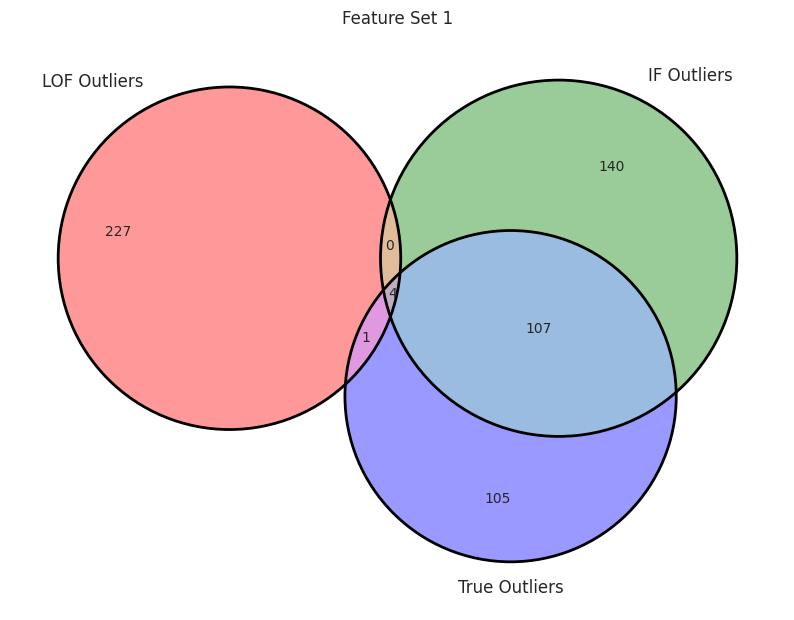

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


For Feature Set 2, True Outliers Count: 217
LOF Outliers for Feature Set 2: 11
IF Outliers for Feature Set 2: 163


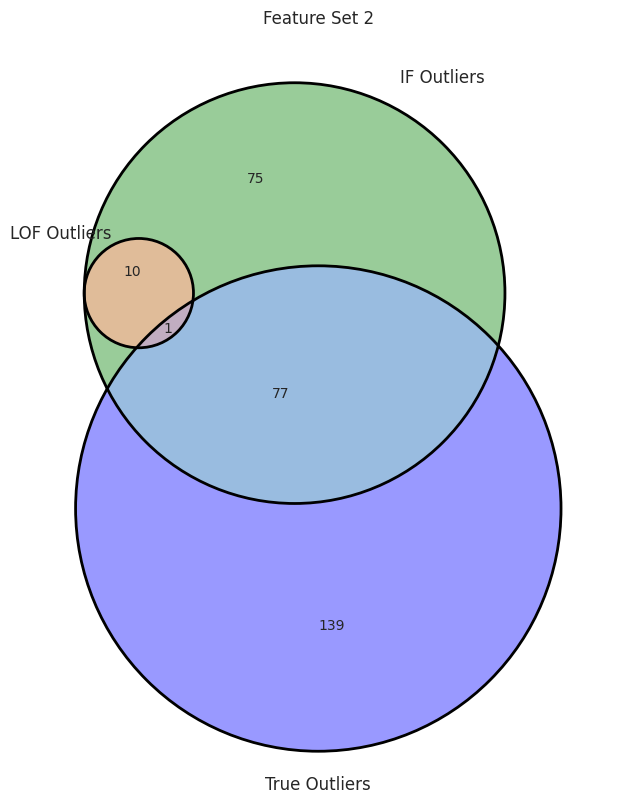

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


For Feature Set 3, True Outliers Count: 217
LOF Outliers for Feature Set 3: 244
IF Outliers for Feature Set 3: 246


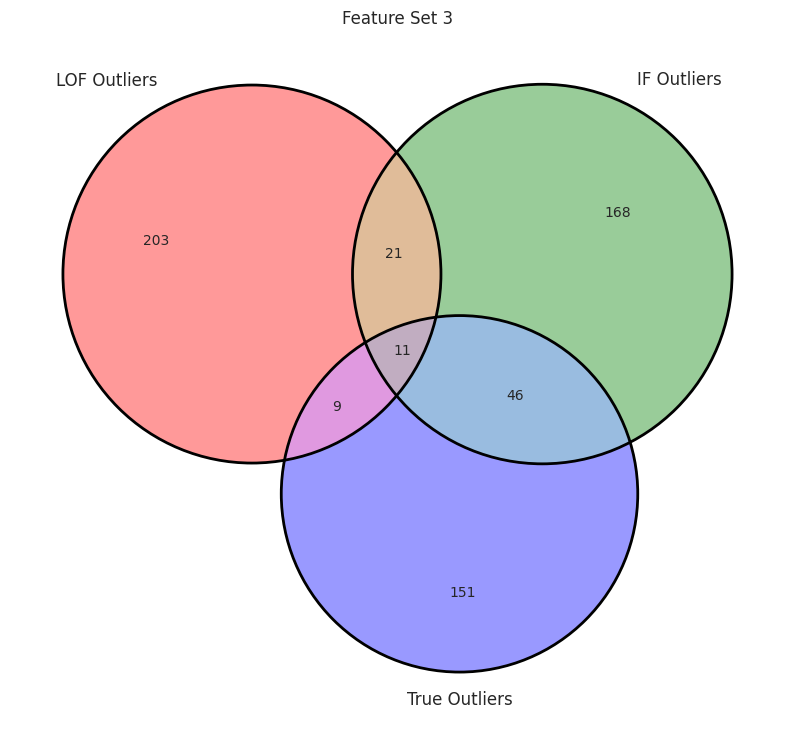

In [ ]:
# ... (Other parts of your code) ...

# Step 1: Check Y_test Values Consistency before the loop starts
print("Original Y_test value counts:")
print(Y_test.value_counts())

feature_sets = [X_selected_train_anochi, X_selected_train_mutual, X_selected_train_DT]
feature_sets_test = [X_selected_test_anochi, X_selected_test_mutual, X_selected_test_DT]

for idx, (X_train_set, X_test_set) in enumerate(zip(feature_sets, feature_sets_test)):

    # Check the lengths of X_test_set and Y_test
    assert len(X_test_set) == len(Y_test), f"Feature set {idx + 1} length mismatch!"

    # Training and prediction for Local Outlier Factor
    lof_model = LocalOutlierFactor(n_neighbors=50, contamination=0.05, novelty=True)
    lof_model.fit(X_train_set)
    Y_predictions_lof = lof_model.predict(X_test_set)

    # Training and prediction for Isolation Forest
    if_model = IsolationForest(contamination=0.05, random_state=0)
    if_model.fit(X_train_set)
    Y_predictions_iso = if_model.predict(X_test_set)

    # Adjusting labels to match the -1 (anomaly) and 1 (normal) convention used by Local Outlier Factor
    adjusted_Y_test = np.where(Y_test == 0, 1, -1)

    # Computing outlier indices
    lof_outlier_indices = set(np.where(Y_predictions_lof == -1)[0])
    if_outlier_indices = set(np.where(Y_predictions_iso == -1)[0])
    true_outlier_indices = set(np.where(Y_test == 1)[0])

    # Step 2: Print counts of true outliers detected for sanity check
    print(f"For Feature Set {idx + 1}, True Outliers Count: {len(true_outlier_indices)}")

    # Step 3: Print out the number of anomalies predicted by each model
    print(f"LOF Outliers for Feature Set {idx + 1}: {len(lof_outlier_indices)}")
    print(f"IF Outliers for Feature Set {idx + 1}: {len(if_outlier_indices)}")

    venn_labels = {
        '100': len(lof_outlier_indices - if_outlier_indices - true_outlier_indices),
        '010': len(if_outlier_indices - lof_outlier_indices - true_outlier_indices),
        '001': len(true_outlier_indices - lof_outlier_indices - if_outlier_indices),
        '110': len(lof_outlier_indices & if_outlier_indices - true_outlier_indices),
        '101': len(lof_outlier_indices & true_outlier_indices - if_outlier_indices),
        '011': len(if_outlier_indices & true_outlier_indices - lof_outlier_indices),
        '111': len(lof_outlier_indices & if_outlier_indices & true_outlier_indices),
    }

    # Plotting the Venn diagram
    plt.figure(figsize=(10, 10))
    v = venn3(subsets=venn_labels, set_labels=('LOF Outliers', 'IF Outliers', 'True Outliers'))
    v_c = venn3_circles(subsets=venn_labels, linestyle='solid')
    plt.title(f"Feature Set {idx + 1}")
    plt.show()


In [ ]:
+model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}',
                                                                     })

,Recall,Precision,F1-Score,time to train,time to predict,total time
KNeighbors - Feature Set 1,98.32%,98.30%,98.31%,0.0,0.2,0.2
KNeighbors - Feature Set 2,97.72%,98.33%,97.91%,0.0,0.8,0.9
KNeighbors - Feature Set 3,97.80%,97.71%,97.75%,0.0,0.2,0.2
KMeans - Feature Set 1,87.69%,91.40%,89.48%,0.6,0.0,0.6
KMeans - Feature Set 2,25.58%,95.79%,35.07%,0.6,0.0,0.7
KMeans - Feature Set 3,94.23%,91.69%,92.88%,0.3,0.0,0.3
Random Forest - Feature Set 1,98.52%,98.48%,98.50%,2.1,0.2,2.3
Random Forest - Feature Set 2,97.72%,98.33%,97.91%,2.9,0.3,3.2
Random Forest - Feature Set 3,98.56%,98.55%,98.56%,2.7,0.2,3.0
XGBoost - Feature Set 1,98.54%,98.53%,98.54%,0.9,0.0,0.9
